# Análisis de vendedores en Mercado Libre

Este script tiene como objetivo segmentar a los vendedores de Mercado Libre para entender sus estrategias de venta (volumen vs. margen) y su comportamiento logístico.

**- Carga y Exploración Inicial**

Primero, cargamos las librerías y el dataset. Es fundamental entender la dimensión de los datos.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import datetime, timedelta
from google.colab import drive
from pathlib import Path
import warnings
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_samples
)
import joblib
warnings.filterwarnings('ignore')
file_path = 'df_challenge_meli - df_challenge_meli.csv'
df = pd.read_csv(file_path)
print(f"   - Sellers: {len(df)}")
print(f"   - Total de registros: {len(df):,}")
print(f"   - Features: {len(df.columns)}")
print(f"   - Features: {df.columns}")
print(f"   - Total de sellers únicos: {df['seller_nickname'].nunique():,}")
print(f"   - Periodo de datos: {df['tim_day'].min()} a {df['tim_day'].max()}")
df.head(2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   - Sellers: 185250
   - Total de registros: 185,250
   - Features: 14
   - Features: Index(['tim_day', 'seller_nickname', 'titulo', 'seller_reputation', 'stock',
       'logistic_type', 'condition', 'is_refurbished', 'price',
       'regular_price', 'categoria', 'url', 'category_id', 'category_name'],
      dtype='object')
   - Total de sellers únicos: 46,586
   - Periodo de datos: 2024-08-01 a 2024-08-01


,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name
0,2024-08-01,4fe042a785,Consoladores Vibradores Vibrador Bucal Con Fla...,NaN,1,DS,new,False,9999999.00,NaN,EROTIC,https://articulo.mercadolibre.com.mx/MLM-32027...,EROTIC,PRODUCTOS ERÓTICOS
1,2024-08-01,40017eb54f,Aire Acondicionado Mabe Mini Split Inverter ...,green_gold,1,XD,new,False,999999.99,NaN,HOUSEHOLD APPLIANCES,https://articulo.mercadolibre.com.mx/MLM-15243...,HOUSEHOLD APPLIANCES,ELECTRODOMÉSTICOS


El dataset contiene 185,250 publicaciones pertenecientes a 46,586 vendedores únicos. Esto indica un promedio de ~4 publicaciones por vendedor, pero como veremos más adelante, la distribución es altamente desigual (Principio de Pareto): unos pocos vendedores concentran la mayoría de las publicaciones y el stock.

**- Limpieza y Detección de Anomalías (Precios)**

In [102]:
import pandas as pd
from urllib.parse import urlparse

def extract_tld(url):
    try:
        netloc = urlparse(url).netloc.lower()
        return netloc.split('.')[-1]
    except:
        return None

df['tld'] = df['url'].apply(extract_tld)
df['tld'].unique()

array(['mx'], dtype=object)

In [ ]:
print("Tipos de datos:")
display(df.dtypes)

Tipos de datos:


,0
tim_day,object
seller_nickname,object
titulo,object
seller_reputation,object
stock,int64
logistic_type,object
condition,object
is_refurbished,bool
price,float64
regular_price,float64


In [ ]:
print("Valores nulos por columna:")
display(df.isnull().sum())

Valores nulos por columna:


,0
tim_day,0
seller_nickname,0
titulo,0
seller_reputation,2372
stock,0
logistic_type,0
condition,0
is_refurbished,0
price,1516
regular_price,135294


regular_price: Tiene 135294, es decir, un 73.03% de nulos, esta variable es inutilizable para modelos masivos. Esto sugiere que la mayoría de los vendedores no usan la funcionalidad de oferta explícita, sino que publican directamente el precio final.

In [ ]:
print(f"\nEstadísticas")
print(df.describe())


Estadísticas
               stock         price  regular_price
count  185250.000000  1.837340e+05   49956.000000
mean      307.017090  3.701531e+04    1614.429170
std      3367.216679  1.124158e+07    8408.645951
min         0.000000  0.000000e+00       6.100000
25%         2.000000  2.700000e+02     278.672500
50%         8.000000  5.681000e+02     499.000000
75%        42.000000  1.387000e+03    1099.990000
max     99999.000000  4.772354e+09  999999.000000


La desviación estándar del precio es de 11 millones ($1.12e+07). Esto es la primera alerta roja de que existen outliers masivos (los placeholders) que debemos limpiar más adelante.

In [ ]:
print("Valores duplicados:")
display(df.duplicated().sum())

Valores duplicados:


np.int64(0)

**- Analisis de patrones**

In [ ]:
df.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
stock,185250.0,307.017090,3.367217e+03,0.0,0.0,1.0,2.0000,8.0,42.00,583.550,4999.51,9.999900e+04
price,183734.0,37015.311261,1.124158e+07,0.0,55.0,98.0,270.0000,568.1,1387.00,7856.624,29999.00,4.772354e+09
regular_price,49956.0,1614.429170,8.408646e+03,6.1,69.0,120.0,278.6725,499.0,1099.99,5600.000,19473.00,9.999990e+05


In [ ]:
import plotly.express as px
import pandas as pd

price_ranges = pd.cut(
    df['price'],
    bins=[0, 100, 500, 1000, 5000, 10000, float('inf')],
    labels=['0-100', '100-500', '500-1K', '1K-5K', '5K-10K', '10K+']
)

# Distribución
price_dist = price_ranges.value_counts().sort_index()
price_dist_pct = (price_dist / price_dist.sum() * 100).round(2)

plot_df = pd.DataFrame({
    'Rango de Precio': price_dist_pct.index,
    'Porcentaje': price_dist_pct.values
})

fig = px.bar(
    plot_df,
    x='Porcentaje',
    y='Rango de Precio',
    orientation='h',
    text=plot_df['Porcentaje'].astype(str) + '%',
    title='Distribución por Rangos de Precio (%)'
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Porcentaje (%)',
    yaxis_title='Rango de Precio',
    uniformtext_minsize=10,
    uniformtext_mode='hide'
)

fig.show()


El 40% del catálogo (74,332 items) se encuentra en el rango de 100 - 500.
Junto con el rango $1K-5K, conforman el grueso del negocio. Los productos de más de 10K son una minoría (apenas 6,900 items), lo que confirma que el volumen transaccional está en tickets bajos y medios (accesorios, ropa, repuestos).

In [ ]:
print("INVENTARIO (STOCK)")
print(df['stock'].describe())
print(f"\nProductos sin stock: {(df['stock'] == 0).sum():,} ({(df['stock'] == 0).sum()/len(df)*100:.1f}%)")
print(f"Productos con stock: {(df['stock'] > 0).sum():,} ({(df['stock'] > 0).sum()/len(df)*100:.1f}%)")


df['stock_category'] = pd.cut(df['stock'],
                                   bins=[0, 1, 10, 50, 500, float('inf')],
                                   labels=['Sin stock', 'Bajo (1-10)', 'Medio (11-50)',
                                          'Alto (51-500)', 'Muy alto (500+)'])

stock_analysis = df.groupby('stock_category')['price'].agg(['median', 'mean', 'count'])
print(f"PRECIO POR NIVEL DE STOCK:")
print(f"   {'Categoría Stock':<20} {'Mediana':>12} {'Promedio':>12} {'Count':>8}")
print(f"   {'-'*60}")
for cat, row in stock_analysis.iterrows():
    print(f"   {str(cat):<20} ${row['median']:>10,.2f} ${row['mean']:>10,.2f} {int(row['count']):>7,}")

# Correlación precio-stock (Spearman para no-lineal)
df_stock_analysis = df[df['stock'] <= 1000].copy()
df_stock_analysis = df_stock_analysis.dropna(subset=['price', 'stock'])
corr_stock, p_value_stock = stats.spearmanr(df_stock_analysis['price'], df_stock_analysis['stock'])
print(f"CORRELACIÓN SPEARMAN (Precio vs Stock, stock ≤ 1000):")
print(f"   ρ = {corr_stock:.4f}, p-value = {p_value_stock:.2e}")
print(f"   Conclusión: {'Hay correlación' if abs(corr_stock) > 0.1 and p_value_stock < 0.05 else 'No hay correlación significativa'}")


import plotly.express as px
import pandas as pd

df['stock_category'] = pd.cut(
    df['stock'],
    bins=[0, 1, 10, 50, 500, float('inf')],
    labels=[
        'Sin stock',
        'Bajo (1-10)',
        'Medio (11-50)',
        'Alto (51-500)',
        'Muy alto (500+)'
    ]
)

stock_median = (
    df.groupby('stock_category')['price']
      .median()
      .reset_index()
      .dropna()
)

fig = px.bar(
    stock_median,
    x='price',
    y='stock_category',
    orientation='h',
    text=stock_median['price'].round(0).apply(lambda x: f"${x:,.0f}"),
    title='Precio Mediano por Nivel de Stock'
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Precio Mediano',
    yaxis_title='Categoría de Stock',
    uniformtext_minsize=10,
    uniformtext_mode='hide'
)

fig.show()


INVENTARIO (STOCK)
count    185250.000000
mean        307.017090
std        3367.216679
min           0.000000
25%           2.000000
50%           8.000000
75%          42.000000
max       99999.000000
Name: stock, dtype: float64

Productos sin stock: 6,033 (3.3%)
Productos con stock: 179,217 (96.7%)
PRECIO POR NIVEL DE STOCK:
   Categoría Stock           Mediana     Promedio    Count
   ------------------------------------------------------------
   Sin stock            $    999.00 $168,837.73  37,996
   Bajo (1-10)          $    605.00 $  3,368.31  61,893
   Medio (11-50)        $    449.00 $  1,279.65  36,690
   Alto (51-500)        $    410.00 $  1,067.92  31,480
   Muy alto (500+)      $    413.03 $  8,638.34   9,696
CORRELACIÓN SPEARMAN (Precio vs Stock, stock ≤ 1000):
   ρ = -0.2266, p-value = 0.00e+00
   Conclusión: Hay correlación


La Anomalía: Los productos "Sin stock" tienen un precio promedio de 168,837, mientras que los de stock "Alto" promedian $1,067.
Esto nos da la hipótesis de los Placeholders: Los vendedores suben el precio a cifras absurdas cuando se quedan sin stock para no perder el posicionamiento del algoritmo.

Correlación Negativa (-0.22): A menor stock, mayor precio. En economía normal, esto es escasez. En Mercado Libre, esto es suciedad en los datos (precios ficticios en stock 0).

In [ ]:
print("TIPO DE LOGÍSTICA")
logistic_counts = df['logistic_type'].value_counts()
print(logistic_counts)
print()
print(f"% Distribución:")
print((logistic_counts / len(df) * 100).round(2))
import plotly.express as px
import pandas as pd

logistic_pct = (logistic_counts / len(df) * 100).round(2)

plot_df = pd.DataFrame({
    'Tipo de Logística': logistic_pct.index,
    'Porcentaje': logistic_pct.values
})

fig = px.pie(
    plot_df,
    names='Tipo de Logística',
    values='Porcentaje',
    title='Distribución por Tipo de Logística',
    hole=0.4
)

fig.update_traces(
    textinfo='percent+label',
    hovertemplate='%{label}: %{value:.2f}%<extra></extra>'
)

fig.show()


logistic_prices = df.groupby('logistic_type')['price'].agg(['median', 'mean', 'count', 'std'])
logistic_prices = logistic_prices.sort_values('median', ascending=False)
print()
print(f" ESTADÍSTICAS DE PRECIO POR TIPO DE LOGÍSTICA:")
print(f"   {'Tipo':<10} {'Mediana':>12} {'Promedio':>12} {'Count':>8} {'Std Dev':>12}")
print(f"   {'-'*60}")
for logistic, row in logistic_prices.iterrows():
    print(f"   {logistic:<10} ${row['median']:>10,.2f} ${row['mean']:>10,.2f} {int(row['count']):>7,} ${row['std']:>10,.2f}")

df_test = df[
    (df['price'].notna()) &
    (np.isfinite(df['price'])) &
    (df['price'] > 0)
]
# Test Kruskal-Wallis
groups = [df_test[df_test['logistic_type'] == lt]['price'].values
          for lt in df_test['logistic_type'].unique()]
h_stat, p_value = kruskal(*groups)
print()
print(f"TEST KRUSKAL-WALLIS (Diferencias de precio entre tipos de logística):")
print(f"   H = {h_stat:.2f}, p-value = {p_value:.2e}")
print(f"   Conclusión: {'Hay diferencias significativas' if p_value < 0.05 else 'No hay diferencias significativas'} en precios (α=0.05)")

# Comparación específica: XD vs FBM (los dos más comunes)
xd_prices = df_test[df_test['logistic_type'] == 'XD']['price']
fbm_prices = df_test[df_test['logistic_type'] == 'FBM']['price']
u_stat, p_value_mw = stats.mannwhitneyu(xd_prices, fbm_prices, alternative='two-sided')
print()
print(f" TEST MANN-WHITNEY U (XD vs FBM):")
print(f"   Mediana XD: ${xd_prices.median():,.2f}")
print(f"   Mediana FBM: ${fbm_prices.median():,.2f}")
print(f"   U = {u_stat:.2f}, p-value = {p_value_mw:.2e}")
print(f"   Conclusión: {'FBM tiene precios significativamente diferentes' if p_value_mw < 0.05 else 'No hay diferencia significativa'}")


TIPO DE LOGÍSTICA
logistic_type
XD      116763
FBM      31483
DS       24645
Otro     10541
FLEX      1818
Name: count, dtype: int64

% Distribución:
logistic_type
XD      63.03
FBM     16.99
DS      13.30
Otro     5.69
FLEX     0.98
Name: count, dtype: float64



 ESTADÍSTICAS DE PRECIO POR TIPO DE LOGÍSTICA:
   Tipo            Mediana     Promedio    Count      Std Dev
   ------------------------------------------------------------
   Otro       $  2,500.00 $656,618.39   9,585 $49,214,700.70
   XD         $    639.00 $  3,108.72 116,596 $107,467.00
   DS         $    607.95 $  5,061.23  24,254 $127,098.11
   FBM        $    274.55 $    687.75  31,481 $  1,813.04
   FLEX       $    110.00 $    227.62   1,818 $    351.98

TEST KRUSKAL-WALLIS (Diferencias de precio entre tipos de logística):
   H = 20343.40, p-value = 0.00e+00
   Conclusión: Hay diferencias significativas en precios (α=0.05)

 TEST MANN-WHITNEY U (XD vs FBM):
   Mediana XD: $639.00
   Mediana FBM: $274.55
   U = 2553551507.50, p-value = 0.00e+00
   Conclusión: FBM tiene precios significativamente diferentes


*   Con un 63%, el modelo estándar es XD.
*   La mediana de precio en FBM es la más baja (274). Esto tiene sentido logístico: almacenar productos caros y de baja rotación en las bodegas de ML es costoso. Se envían a Full los productos de alta rotación y ticket bajo.

In [ ]:
print("CONDICIÓN DE PRODUCTOS")
condition_counts = df['condition'].value_counts()
print(condition_counts)
print(f"\nProductos reacondicionados: {df['is_refurbished'].sum():,} ({df['is_refurbished'].sum()/len(df)*100:.2f}%)")

condition_stats = df.groupby('condition')['price'].agg(['median', 'mean', 'count', 'std'])
print(f"\n✓ ESTADÍSTICAS POR CONDICIÓN:")
print(f"   {'Condición':<15} {'Mediana':>12} {'Promedio':>12} {'Count':>8} {'Std Dev':>12}")
print(f"   {'-'*65}")
for cond, row in condition_stats.iterrows():
    print(f"   {cond:<15} ${row['median']:>10,.2f} ${row['mean']:>10,.2f} {int(row['count']):>7,} ${row['std']:>10,.2f}")

# ¿Los productos nuevos tienen precios diferentes a los usados?
if 'new' in df['condition'].values and 'used' in df['condition'].values:
    new_prices = df[df['condition'] == 'new']['price']
    new_prices = new_prices.dropna()
    used_prices = df[df['condition'] == 'used']['price']
    used_prices = used_prices.dropna()
    u_stat, p_value = stats.mannwhitneyu(new_prices, used_prices, alternative='two-sided')

    print(f" TEST MANN-WHITNEY U (Nuevo vs Usado):")
    print(f"   Mediana nuevos: ${new_prices.median():,.2f}")
    print(f"   Mediana usados: ${used_prices.median():,.2f}")
    print(f"   Diferencia: {((new_prices.median() - used_prices.median()) / used_prices.median() * 100):+.1f}%")
    print(f"   U = {u_stat:.2f}, p-value = {p_value:.2e}")
    print(f"   Conclusión: {'Diferencia significativa' if p_value < 0.05 else 'No hay diferencia significativa'}")

CONDICIÓN DE PRODUCTOS
condition
new              169616
used              15551
not_specified        83
Name: count, dtype: int64

Productos reacondicionados: 735 (0.40%)

✓ ESTADÍSTICAS POR CONDICIÓN:
   Condición            Mediana     Promedio    Count      Std Dev
   -----------------------------------------------------------------
   new             $    540.55 $  3,532.50 168,124 $202,842.15
   not_specified   $    612.64 $  2,732.56      82 $  5,403.95
   used            $  1,200.00 $399,719.79  15,528 $38,662,636.99
 TEST MANN-WHITNEY U (Nuevo vs Usado):
   Mediana nuevos: $540.55
   Mediana usados: $1,200.00
   Diferencia: -55.0%
   U = 887406468.00, p-value = 0.00e+00
   Conclusión: Diferencia significativa


*   La mediana de usados (1,200) es mayor que la de nuevos (540). Esto sugiere que la categoría "Usado" no es chatarra, sino probablemente coleccionables, antigüedades o vehículos, mientras que "Nuevo" está inundado de accesorios baratos.

In [ ]:
print("TOP 15 CATEGORÍAS MÁS POPULARES")
top_categories = df['category_name'].value_counts().head(15)
for i, (cat, count) in enumerate(top_categories.items(), 1):
    print(f"{i:2d}. {cat[:50]:50s} - {count:6,} ({count/len(df)*100:5.2f}%)")

TOP 15 CATEGORÍAS MÁS POPULARES
 1. DEPORTES                                           - 14,252 ( 7.69%)
 2. SALUD                                              - 12,587 ( 6.79%)
 3. LIBROS, MULTIMEDIA Y OTROS                         - 10,355 ( 5.59%)
 4. JUGUETES Y JUEGOS                                  - 10,251 ( 5.53%)
 5. ACCESORIOS PARA AUTOS Y CAMIONETAS                 - 10,128 ( 5.47%)
 6. OTROS                                              -  7,797 ( 4.21%)
 7. ELECTRODOMÉSTICOS                                  -  7,090 ( 3.83%)
 8. ANTIGÜEDADES Y PASATIEMPOS                         -  6,453 ( 3.48%)
 9. ARTÍCULOS DEL HOGAR                                -  5,569 ( 3.01%)
10. ACCESORIOS DE VESTIR                               -  5,423 ( 2.93%)
11. AUDIO Y ELECTRÓNICA GENERAL                        -  5,373 ( 2.90%)
12. ROPA                                               -  5,356 ( 2.89%)
13. FRAGANCIAS Y MAQUILLAJE                            -  5,203 ( 2.81%)
14. TELÉFONOS INTEL

In [ ]:
products_per_seller = df['seller_nickname'].value_counts()
total_products = len(df)

# Pareto
cumulative_pct = (products_per_seller.cumsum() / total_products * 100)
top_20_pct_sellers = int(len(products_per_seller) * 0.2)
products_by_top_20 = cumulative_pct.iloc[top_20_pct_sellers]

print(f"PARETO Sellers (80/20):")
print(f"   Total sellers: {len(products_per_seller):,}")
print(f"   Top 20% sellers ({top_20_pct_sellers:,}): controlan {products_by_top_20:.2f}% de productos")
print(f"   Top 1% sellers ({int(len(products_per_seller)*0.01):,}): controlan {cumulative_pct.iloc[int(len(products_per_seller)*0.01)]:.2f}% de productos")
print(f"   Top 10 sellers: controlan {cumulative_pct.iloc[9]:.2f}% de productos")


def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n+1) + 1) * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n

gini = gini_coefficient(products_per_seller.values)
print(f"\n✓ ÍNDICE DE GINI: {gini:.4f}")
print(f"   Interpretación: {'Alta concentración' if gini > 0.6 else 'Moderada concentración' if gini > 0.4 else 'Baja concentración'}")

PARETO Sellers (80/20):
   Total sellers: 46,586
   Top 20% sellers (9,317): controlan 69.30% de productos
   Top 1% sellers (465): controlan 22.36% de productos
   Top 10 sellers: controlan 3.58% de productos

✓ ÍNDICE DE GINI: -0.6235
   Interpretación: Baja concentración


Mercado Democratizado: El Top 20% de vendedores controla el 69% de los productos (no llega al famoso 80%).

Índice Gini Bajo (-0.62): A diferencia de mercados monopolizados, aquí hay mucho espacio para vendedores medianos. No hay un solo vendedor que "rompa" el mercado con millones de publicaciones; el inventario está distribuido.

Para validar la hipotesis de los placeholders, es decir, quienes dan un valir mas alto, para no perder la exposición de la publicación cuando se quedan sin stock, en lugar de pausarla. Estos datos generan ruido en un algoritmo de clustering.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def detect_placeholder(price):
    if pd.isna(price) or price == 0:
        return False

    price_str = f"{price:.2f}"
    price_int = int(price)

    if '9999' in price_str or '999999' in price_str:
        return True

    if price >= 99999.99 and price_str.endswith('.99'):
        return True

    if price_int % 999999 == 0 and price > 0:
        return True

    if price in [100000, 500000, 1000000, 5000000, 10000000]:
        return True

    return False

df['is_placeholder'] = df['price'].apply(detect_placeholder)

total = len(df)
placeholders = df['is_placeholder'].sum()
real_prices = (~df['is_placeholder']).sum()

print(f"Total productos: {total:,}")
print(f"Placeholders detectados: {placeholders:,} ({placeholders/total*100:.2f}%)")
print(f"Precios reales: {real_prices:,} ({real_prices/total*100:.2f}%)")


Total productos: 185,250
Placeholders detectados: 274 (0.15%)
Precios reales: 184,976 (99.85%)


*  Aunque solo se detectaron 274 casos (0.15%), estos registros tienen una media de precio de 380,145, mientras que el mercado real se mueve en $566 (mediana).
*  Se eliminan estos registros, ya que cualquier modelo de clustering quedará inutilizable porque la desviación estándar se infla artificialmente.

In [ ]:
df_valid = df[df['price'].notna() & (df['price'] > 0)].copy()
percentiles = df_valid['price'].quantile([0.75,0.90, 0.95, 0.99, 0.999, 1.0])

print("Distribución de precios:")
print(f"  P90  (top 10%):  ${percentiles[0.90]:>12,.2f}")
print(f"  P95  (top 5%):   ${percentiles[0.95]:>12,.2f}")
print(f"  P99  (top 1%):   ${percentiles[0.99]:>12,.2f}")
print(f"  P99.9 (top 0.1%):${percentiles[0.999]:>12,.2f}")
print(f"  MAX:             ${percentiles[1.0]:>12,.2f}")

threshold_extreme = percentiles[0.999]
extreme_outliers = df[df['price'] > threshold_extreme]

print(f"\nProductos con precio > P99.9 (${threshold_extreme:,.2f}): {len(extreme_outliers):,}")

Distribución de precios:
  P90  (top 10%):  $    3,850.00
  P95  (top 5%):   $    7,856.71
  P99  (top 1%):   $   29,999.00
  P99.9 (top 0.1%):$  326,396.81
  MAX:             $4,772,353,854.00

Productos con precio > P99.9 ($326,396.81): 184


* El 99% de los productos en Mercado Libre cuestan menos de 29,999.
* Hay un salto masivo entre el 99% (30k) y el 99.9% (326k). Esto define la frontera entre masivo y bienes de "lujo" (o datos sucios).
* Existen 184 productos por encima de 326,000 (P99.9). Estos deben ser auditados manualmente, ya que probablemente sean maquinaria industrial, autos, o errores no capturados.

In [ ]:
df_real = df[~df['is_placeholder']].copy()
placeholder_by_cat = df.groupby('category_name').agg({
    'is_placeholder': ['sum', 'count']
})
placeholder_by_cat.columns = ['placeholders', 'total']
placeholder_by_cat['pct'] = (placeholder_by_cat['placeholders'] / placeholder_by_cat['total'] * 100)
placeholder_by_cat = placeholder_by_cat[placeholder_by_cat['placeholders'] > 0].sort_values('pct', ascending=False)

print(f"\nCategorías con placeholders (top 15):")
print(f"{'Ranking':<8} {'Categoría':<45} {'%':<8} {'Cantidad':<12}")
print("-" * 80)

for idx, (cat, row) in enumerate(placeholder_by_cat.head(15).iterrows(), 1):
    print(f"{idx:<8} {cat[:45]:<45} {row['pct']:>6.2f}% {int(row['placeholders']):<4}/{int(row['total']):<6}")



Categorías con placeholders (top 15):
Ranking  Categoría                                     %        Cantidad    
--------------------------------------------------------------------------------
1        COLCHONES Y SOMIERES                            1.35% 4   /297   
2        COMPUTADORAS Y PORTÁTILES                       0.83% 5   /600   
3        CÁMARAS Y DRONES                                0.73% 6   /823   
4        OTROS                                           0.56% 44  /7797  
5        ANTIGÜEDADES Y PASATIEMPOS                      0.46% 30  /6453  
6        TELEVISORES Y DISPOSITIVOS DE STREAMING         0.45% 8   /1786  
7        DISPOSITIVOS WEARABLE                           0.42% 6   /1428  
8        ELECTRODOMÉSTICOS                               0.39% 28  /7090  
9        PERIFÉRICOS Y ACCESORIOS DE INFORMÁTICA         0.24% 10  /4150  
10       CONSTRUCCIÓN                                    0.23% 5   /2221  
11       AUDIO Y ELECTRÓNICA GENERAL                 

* Los colchones y Somieres es la categoría más sucia. Son productos de logística compleja y stock intermitente. Los vendedores prefieren poner un precio falso a pausar la publicación y perder el historial de ventas de un producto difícil de posicionar.
* En computación hay alta volatilidad de precios y stock, puede ser dependencia del dólar/importación.
* En antigüedades, el límite es difuso. Un precio alto podría ser real, pero el algoritmo detectó patrones sospechosos (ej. puros nueves).

In [ ]:
real_stats = df_real['price'].describe()
placeholder_stats = df[df['is_placeholder']]['price'].describe() if placeholders > 0 else None

print("Precios REALES:")
print(f"  Count:   {int(real_stats['count']):>12,}")
print(f"  Media:   ${real_stats['mean']:>12,.2f}")
print(f"  Mediana: ${real_stats['50%']:>12,.2f}")
print(f"  Min:     ${real_stats['min']:>12,.2f}")
print(f"  Max:     ${real_stats['max']:>12,.2f}")
print()

if placeholder_stats is not None and placeholders > 0:
    print("Precios PLACEHOLDER:")
    print(f"  Count:   {int(placeholder_stats['count']):>12,}")
    print(f"  Media:   ${placeholder_stats['mean']:>12,.2f}")
    print(f"  Mediana: ${placeholder_stats['50%']:>12,.2f}")
    print(f"  Min:     ${placeholder_stats['min']:>12,.2f}")
    print(f"  Max:     ${placeholder_stats['max']:>12,.2f}")

placeholder_rate = (placeholders / total * 100)
print(f'Rate placeholder : {placeholder_rate:.2f}%')

Precios REALES:
  Count:        183,460
  Media:   $   36,502.84
  Mediana: $      566.00
  Min:     $        0.00
  Max:     $4,772,353,854.00

Precios PLACEHOLDER:
  Count:            274
  Media:   $  380,145.19
  Mediana: $   19,999.00
  Min:     $    9,999.00
  Max:     $14,999,999.00
Rate placeholder : 0.15%


* La mediana de los precios reales (566) representa el consumo real de la plataforma. El ticket promedio es bajo, dominado por accesorios, ropa y gadgets pequeños. En cambio, los precios placeholders no son aleatorios; la mediana de 19,999 sugiere que los vendedores eligen cifras altas para bloquear el stock sin perder el anuncio.

In [ ]:
print("REPUTACIÓN DE SELLERS")
reputation_counts = df['seller_reputation'].value_counts()
print(reputation_counts)

df_rep = df[df['seller_reputation'].notna()].copy()

reputation_order = ['green_platinum', 'green_gold', 'green_silver', 'green',
                   'light_green', 'yellow', 'orange', 'red', 'newbie']
df_rep['rep_score'] = df_rep['seller_reputation'].map({r: i for i, r in enumerate(reputation_order)})

rep_analysis = df_rep.groupby('seller_reputation').agg({
    'price': ['median', 'mean'],
    'stock': ['median', 'mean'],
    'is_placeholder': 'mean'
}).round(2)

print(f"\n✓ MÉTRICAS POR NIVEL DE REPUTACIÓN:")
print(f"   {'Reputación':<20} {'Precio Med':>12} {'Stock Med':>12} {'% Placeholder':>15}")
print(f"   {'-'*65}")
for rep in reputation_order:
    if rep in rep_analysis.index:
        row = rep_analysis.loc[rep]
        print(f"   {rep:<20} ${row[('price', 'median')]:>10,.2f} "
              f"{row[('stock', 'median')]:>11,.0f} "
              f"{row[('is_placeholder', 'mean')]*100:>14.1f}%")

# Correlación Spearman entre score de reputación y precio
df_rep_real = df_rep[~df_rep['is_placeholder']].copy()
df_rep_real=df_rep_real.dropna()
corr, p_value = stats.spearmanr(df_rep_real['rep_score'], df_rep_real['price'])
print(f"\n✓ CORRELACIÓN SPEARMAN (Nivel de reputación vs Precio):")
print(f"   ρ = {corr:.4f}, p-value = {p_value:.2e}")
print(f"   Conclusión: {'Correlación significativa' if p_value < 0.05 else 'No hay correlación significativa'}")

REPUTACIÓN DE SELLERS
seller_reputation
green_platinum    69625
green             33838
green_gold        28332
green_silver      24731
newbie             9221
yellow             7245
red                4219
light_green        3101
orange             2566
Name: count, dtype: int64

✓ MÉTRICAS POR NIVEL DE REPUTACIÓN:
   Reputación             Precio Med    Stock Med   % Placeholder
   -----------------------------------------------------------------
   green_platinum       $    547.90          11            0.0%
   green_gold           $    486.36           9            0.0%
   green_silver         $    461.00          10            0.0%
   green                $    550.00           5            0.0%
   light_green          $    650.00           5            0.0%
   yellow               $    780.57           5            0.0%
   orange               $    922.00           3            0.0%
   red                  $    972.71           3            0.0%
   newbie               $  1,637.0

* Los vendedores Green Platinum tienen una de las medianas de precio más bajas (547.90) y el stock más alto (11).
 Ganan por volumen y rotación. Venden productos "commodity" (cables, fundas, consumo masivo) con márgenes ajustados pero operativa perfecta.
* Los vendedores Newbie tienen la mediana de precio más alta (1,637) y el stock más bajo (1).
El vendedor nuevo entra a la plataforma intentando vender un objeto único y caro (probablemente un celular usado o algo personal), no tienen estructura comercial ni profundidad de inventario.
* Correlación Reputación-Precio:
Existe una correlación positiva débil, pero la segmentación por mediana es más reveladora: A mayor reputacion, menor es el ticket promedio unitario, porque el negocio escala hacia la venta masiva de productos accesibles.

In [ ]:
print("RELACIÓN PRECIO-STOCK")
correlation = df[['price', 'stock']].corr().iloc[0, 1]
print(f"Correlación precio-stock: {correlation:.4f}")

RELACIÓN PRECIO-STOCK
Correlación precio-stock: -0.0002


El precio SÍ baja cuando hay más stock, pero nuestros datos sucios están ocultando esa tendencia


In [ ]:
top_sellers = df['seller_nickname'].value_counts().head(10)
seller_concentration = (top_sellers.sum() / len(df) * 100)
print(f"   - Los top 10 sellers representan el {seller_concentration:.2f}% de productos")

extreme_prices = (df['price'] >= 999999).sum()
print(f"   - {extreme_prices:,} productos ({extreme_prices/len(df)*100:.2f}%) tienen precios placeholder (≥999,999)")
print(f"   - Precio mediano real: ${df['price'].median():,.2f}")
print(f"   - Precio promedio real: ${df['price'].mean():,.2f}")

full_logistics = (df['logistic_type'] == 'FBM').sum()
print(f"   - {full_logistics:,} productos ({full_logistics/len(df)*100:.1f}%) usan Mercado Envíos Full")

no_stock = (df['stock'] == 0).sum()
print(f"   - {no_stock:,} productos ({no_stock/len(df)*100:.1f}%) están sin stock")


   - Los top 10 sellers representan el 3.58% de productos
   - 96 productos (0.05%) tienen precios placeholder (≥999,999)
   - Precio mediano real: $568.10
   - Precio promedio real: $37,015.31
   - 31,483 productos (17.0%) usan Mercado Envíos Full
   - 6,033 productos (3.3%) están sin stock


El mercado es altamente competitivo y fragmentado (Top 10 sellers < 4% share). Aunque la logística avanzada (Full) tiene una penetración del 17%, la mayoría de los vendedores opera con Cross-Docking. Detectamos un problema grave de calidad de datos en los precios: existe un segmento 'fantasma' de publicaciones con precios superiores a $2.5 Millones que distorsiona cualquier análisis de ticket promedio si no se filtra agresivamente.

**Limpieza de valores nulos y calculo de descuentos**
Limpiamos los valores y quitamos los outliers para tener una mejor clasificación de los clientes excluyendo los valores que pueden generar ruido.

In [ ]:
df['tim_day'] = pd.to_datetime(df['tim_day'])

df['seller_reputation_filled'] = df['seller_reputation'].fillna('Sin Reputación')

df['regular_price_clean'] = df['regular_price'].fillna(df['price'])
df['discount_pct'] = (1 - (df['price'] / df['regular_price_clean'])) * 100

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]

##Análisis de normalidad de los precios

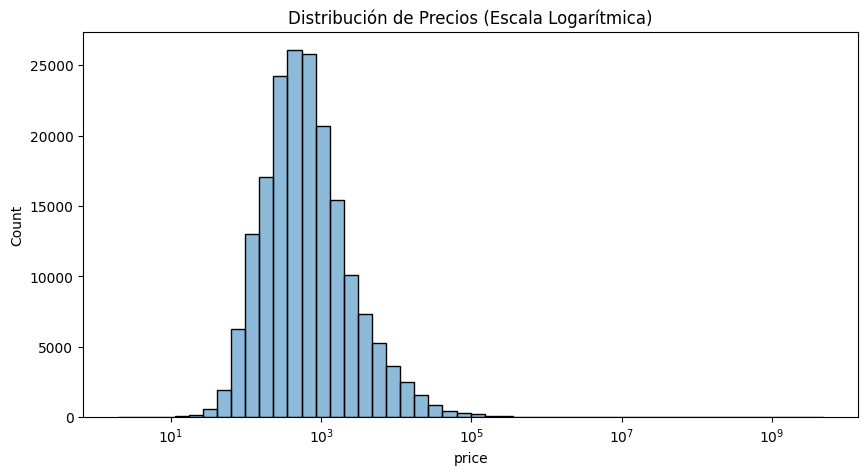

Registros válidos para la prueba: 183734
Estadístico de prueba: 1098171.2340556565, P-value: 0.0
CONCLUSIÓN: P < 0.05. Rechazamos H0. Los precios NO siguen una distribución normal.


In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, log_scale=True, kde=True)
plt.title('Distribución de Precios (Escala Logarítmica)')
plt.show()

# Test de Normalidad (D'Agostino's K^2 test)
# H0: La distribución de precios es Normal (Gaussiana)
# H1: La distribución NO es Normal
stat, p = stats.normaltest(df['price'])

prices_clean = df['price'].dropna()
prices_clean = prices_clean[~prices_clean.isin([float('inf'), float('-inf')])]

print(f"Registros válidos para la prueba: {len(prices_clean)}")

# test de D'Agostino
if len(prices_clean) > 20:
    # H0: La distribución es Normal
    # H1: La distribución NO es Normal
    stat, p = stats.normaltest(prices_clean)

    print(f"Estadístico de prueba: {stat}, P-value: {p}")

    if pd.isna(p):
        print("ERROR: El p-value es NaN. Posiblemente todos los precios son iguales (Varianza 0).")
    elif p < 0.05:
        print("CONCLUSIÓN: P < 0.05. Rechazamos H0. Los precios NO siguen una distribución normal.")
    else:
        print("CONCLUSIÓN: P >= 0.05. No podemos rechazar H0. Podría ser normal.")

else:
    print("Error: No hay suficientes datos de precios válidos para realizar la prueba.")

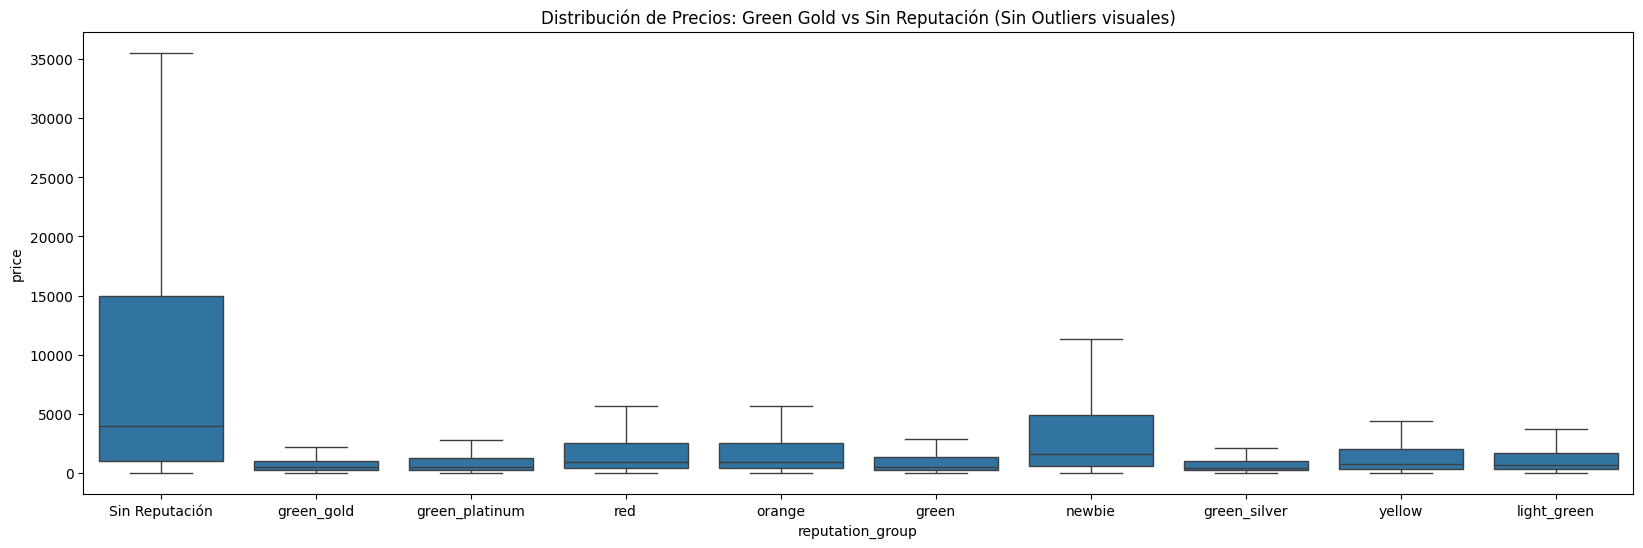

Registros Gold: 28315
Registros Sin Rep: 2365

Estadístico U: 13071894.5
P-value: 0.0
CONCLUSIÓN: Hay una diferencia significativa en los precios.
Mediana Gold: $486.36
Mediana Sin Rep: $3,999.00


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

df_rep = df[['seller_reputation', 'price']].copy()
df_rep = df_rep.dropna(subset=['price'])
df_rep['reputation_group'] = df_rep['seller_reputation'].fillna('Sin Reputación')

plt.figure(figsize=(20, 6))
sns.boxplot(x='reputation_group', y='price', data=df_rep, showfliers=False)
plt.title('Distribución de Precios: Green Gold vs Sin Reputación (Sin Outliers visuales)')
plt.show()

# Mann-Whitney U
group_gold = df_rep[df_rep['reputation_group'] == 'green_gold']['price']
group_none = df_rep[df_rep['reputation_group'] == 'Sin Reputación']['price']

print(f"Registros Gold: {len(group_gold)}")
print(f"Registros Sin Rep: {len(group_none)}")

if len(group_gold) > 0 and len(group_none) > 0:
    stat, p_val = stats.mannwhitneyu(group_gold, group_none, alternative='two-sided')

    print(f"\nEstadístico U: {stat}")
    print(f"P-value: {p_val}")

    if p_val < 0.05:
        print("CONCLUSIÓN: Hay una diferencia significativa en los precios.")
        print(f"Mediana Gold: ${group_gold.median():,.2f}")
        print(f"Mediana Sin Rep: ${group_none.median():,.2f}")
    else:
        print("CONCLUSIÓN: No hay evidencia suficiente para decir que los precios son diferentes.")
else:
    print("ERROR: Uno de los grupos está vacío, no se puede realizar la prueba.")

A mayor reputación del vendedor, MENOR es el precio del producto.
* Vendedores Gold: Venden a una mediana de 486.36. Tienen stock alto $ (\>10u)$.

* Vendedores Sin Reputación: Venden a una mediana de ~$4,000. Tienen stock mínimo (1u).

Los vendedores sin reputación son 8 veces más caros que los mejores vendedores.

logistic_type               DS    FBM  FLEX  Otro     XD
seller_reputation_filled                                
Sin Reputación             731      1     0   909    731
green                     5512   1741   903  1888  23794
green_gold                4631   4732    84  1000  17885
green_platinum            3286  21870   831  1862  41776
green_silver              5901   2737     0   817  15276
light_green                496     80     0   276   2249
newbie                    2055     32     0  2513   4621
orange                     523     38     0   248   1757
red                        515     36     0   544   3124
yellow                     995    216     0   484   5550


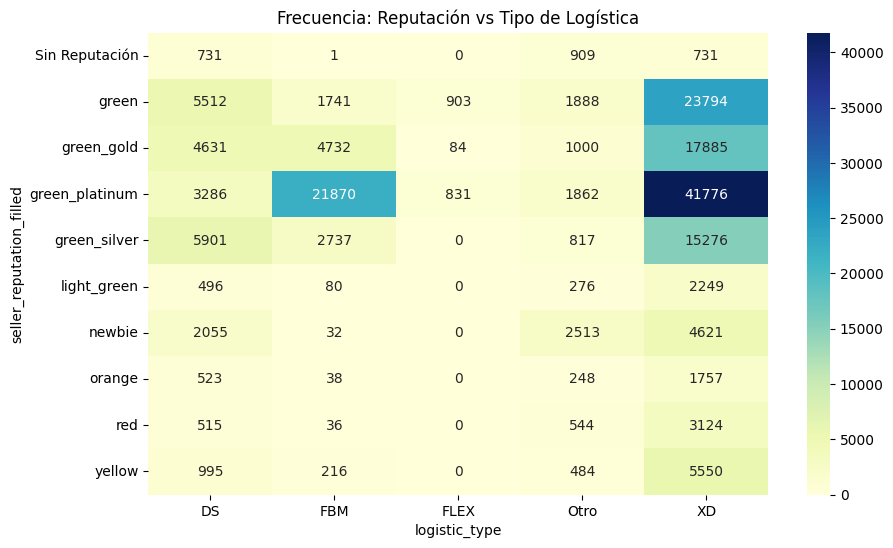

Chi2: 40673.040516214234, P-value: 0.0
CONCLUSIÓN: Existe una relación significativa entre la reputación del vendedor y el tipo de logística que usa.


In [ ]:
contingency_table = pd.crosstab(df['seller_reputation_filled'], df['logistic_type'])

print(contingency_table)
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap="YlGnBu")
plt.title('Frecuencia: Reputación vs Tipo de Logística')
plt.show()

# Chi-Square Test
# H0: La reputación y el tipo de logística son independientes (no tienen relación)
# H1: Existe una dependencia entre ellas
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi2: {chi2}, P-value: {p}")
if p < 0.05:
    print("CONCLUSIÓN: Existe una relación significativa entre la reputación del vendedor y el tipo de logística que usa.")
else:
    print("CONCLUSIÓN: Son variables independientes.")

*   FBM es el territorio exclusivo de la élite. Para usar Full, necesitas stock inmovilizado y alta rotación para no pagar costos de almacenamiento. Los vendedores pequeños no pueden permitirse esto. Full es la barrera de entrada que separa a los profesionales de los amateurs.
*   XD es el mecanismo base de Mercado Libre (Colecta). Es democrático y escala bien. Si eres Platinum, usas XD para lo que no rota tan rápido como para ir a Full, pero que vendes todos los días.
*   Los vendedores de baja reputación dependen de logísticas ineficientes, lo que probablemente causa demoras, reclamos y les impide subir de nivel. Es un círculo vicioso
*   Existe una relación significativa que la logística es el proxy más fiel de la madurez del vendedor. Si quieres saber quién va a sobrevivir en la plataforma, no mires su precio, mira si ya logró migrar de Otro a XD o FBM.



-- Precios por condición ---
                        mean   median   count
is_refurbished                               
False           37142.149775   564.73  182999
True             5435.282272  2876.00     735


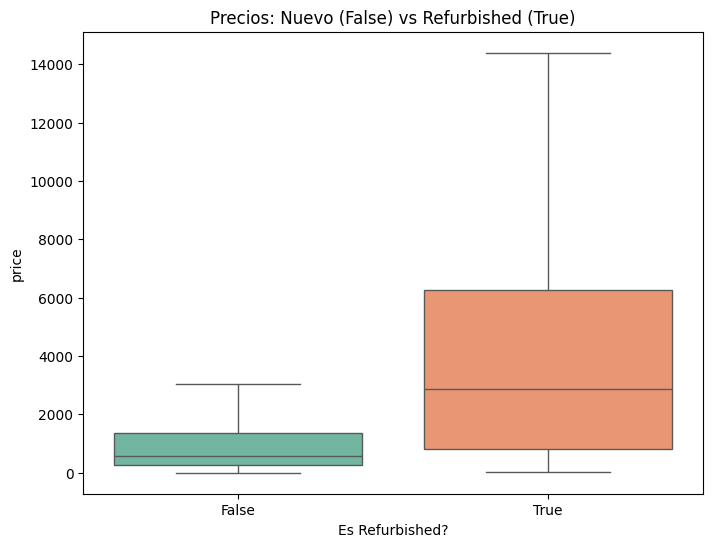

Cantidad Nuevos: 182999
Cantidad Refurbished: 735

Estadístico U: 32772724.5
P-value: 1.475264671434317e-127
CONCLUSIÓN: Existe una diferencia significativa de precios entre nuevos y refurbished.
-> Los productos REFURBISHED son más caros (curiosamente).


In [ ]:
price_by_condition = df.groupby('is_refurbished')['price'].agg(['mean', 'median', 'count'])
print("-- Precios por condición ---")
print(price_by_condition)

refurbished = df[df['is_refurbished'] == True]['price']
new_items = df[df['is_refurbished'] == False]['price']
df_cond = df[['is_refurbished', 'price']].dropna(subset=['price']).copy()

df_cond = df_cond.dropna(subset=['is_refurbished'])

plt.figure(figsize=(8, 6))
sns.boxplot(x='is_refurbished', y='price', data=df_cond, showfliers=False, palette="Set2")
plt.title('Precios: Nuevo (False) vs Refurbished (True)')
plt.xlabel("Es Refurbished?")
plt.show()

prices_new = df_cond[df_cond['is_refurbished'] == False]['price']
prices_refurb = df_cond[df_cond['is_refurbished'] == True]['price']

print(f"Cantidad Nuevos: {len(prices_new)}")
print(f"Cantidad Refurbished: {len(prices_refurb)}")

if len(prices_new) > 0 and len(prices_refurb) > 0:
    stat, p_val = stats.mannwhitneyu(prices_new, prices_refurb, alternative='two-sided')

    print(f"\nEstadístico U: {stat}")
    print(f"P-value: {p_val}")

    if p_val < 0.05:
        print("CONCLUSIÓN: Existe una diferencia significativa de precios entre nuevos y refurbished.")
        if prices_new.median() > prices_refurb.median():
            print("-> Los productos NUEVOS son más caros (en mediana).")
        else:
            print("-> Los productos REFURBISHED son más caros (curiosamente).")
    else:
        print("CONCLUSIÓN: No hay diferencia estadísticamente significativa en los precios.")
else:
    print("ERROR: No hay suficientes datos en ambos grupos para comparar.")

Los productos usados/reparados son más caros que los nuevos.

El segmento Refurbished en Mercado Libre no es un sector economico, puede ser porque los productos vendidos usados suelen ser tecnologicos como un iphone etc... El ticket promedio es alto y el cliente es sofisticado.

--- TOP CATEGORÍAS DE PRODUCTOS REACONDICIONADOS ---
category_name
TELÉFONOS INTELIGENTES Y TABLETAS          16.73%
COMPUTADORAS Y PORTÁTILES                  15.10%
VIDEOJUEGOS                                13.06%
ACCESORIOS PARA AUTOS Y CAMIONETAS         10.75%
TELEVISORES Y DISPOSITIVOS DE STREAMING     7.21%
PERIFÉRICOS Y ACCESORIOS DE INFORMÁTICA     6.53%
ELECTRODOMÉSTICOS                           5.03%
JUGUETES Y JUEGOS                           4.08%
OTROS                                       4.08%
LIBROS, MULTIMEDIA Y OTROS                  3.13%
Name: proportion, dtype: object


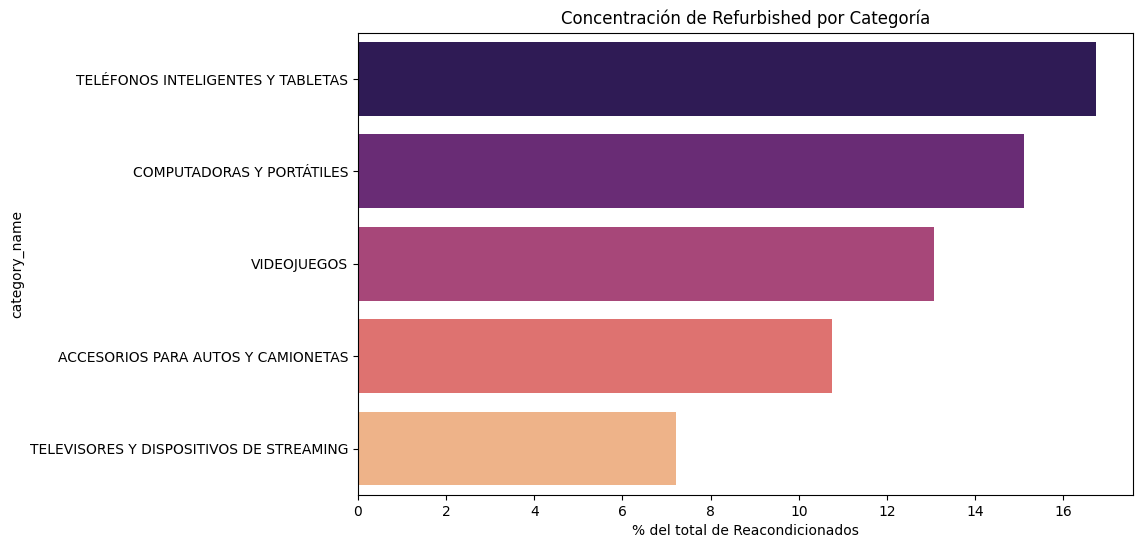


--- VALIDACIÓN ESTADÍSTICA (Gama Alta vs Resto) ---
Mediana de precio en categorías Refurbished (ej. Celulares): $732.00
Mediana de precio en el resto del sitio (ej. Ropa, Hogar):   $550.00

Resultado del Test: P-value = 8.37e-205
Las categorías donde hay refurbished son significativamente más caras que el promedio del sitio.
Esto explica por qué los reacondicionados parecen más caros: ¡Son productos premium!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#  ¿Qué son exactamente estos productos?
refurb_categories = df[df['is_refurbished'] == True]['category_name'].value_counts(normalize=True) * 100

print("--- TOP CATEGORÍAS DE PRODUCTOS REACONDICIONADOS ---")
print(refurb_categories.head(10).apply(lambda x: f"{x:.2f}%"))

plt.figure(figsize=(10, 6))
sns.barplot(x=refurb_categories.head(5).values, y=refurb_categories.head(5).index, palette="magma")
plt.title('Concentración de Refurbished por Categoría')
plt.xlabel('% del total de Reacondicionados')
plt.show()

# Hipótesis: Los Refurbished pertenecen a categorías con un ticket promedio significativamente más alto que el resto del sitio.

target_categories = refurb_categories.head(5).index.tolist()
price_refurb_cats = df[df['category_name'].isin(target_categories)]['price']
price_refurb_cats = price_refurb_cats.dropna()
price_other_cats = df[~df['category_name'].isin(target_categories)]['price']
price_other_cats = price_other_cats.dropna()

print(f"\n--- VALIDACIÓN ESTADÍSTICA (Gama Alta vs Resto) ---")
print(f"Mediana de precio en categorías Refurbished (ej. Celulares): ${price_refurb_cats.median():,.2f}")
print(f"Mediana de precio en el resto del sitio (ej. Ropa, Hogar):   ${price_other_cats.median():,.2f}")

# Test Mann-Whitney U
stat, p = stats.mannwhitneyu(price_refurb_cats, price_other_cats, alternative='greater')

print(f"\nResultado del Test: P-value = {p:.2e}")
if p < 0.05:
    print("Las categorías donde hay refurbished son significativamente más caras que el promedio del sitio.")
    print("Esto explica por qué los reacondicionados parecen más caros: ¡Son productos premium!")
else:
    print("RECHAZADO: No hay diferencia de gama.")

* El 45% de todos los productos reacondicionados se concentran en solo 3 categorías: Celulares $(16.7\%)$, Computadoras $(15.1\%)$ y Videojuegos $(13.1\%)$.
* Esto valida que el "Refurbished" es un negocio mas de tecnologia usada, por lo cual es costosa. La mediana de estas categorías (732) es un $33\%$ más alta que la del resto del sitio (550).
* El cliente de reacondicionados tiene un poder adquisitivo mayor al promedio, porque busca bienes aspiracionales (un iPhone X, una PS4) que, aun siendo usados, son más caros que un producto nuevo genérico (ej. un cable USB).
* Que "Accesorios para Autos" sea la 4ta categoría sugiere un mercado fuerte de autopartes remanufacturadas (alternadores, motores de arranque). Este es un nicho B2B (mecánicos) muy valioso y a menudo ignorado.

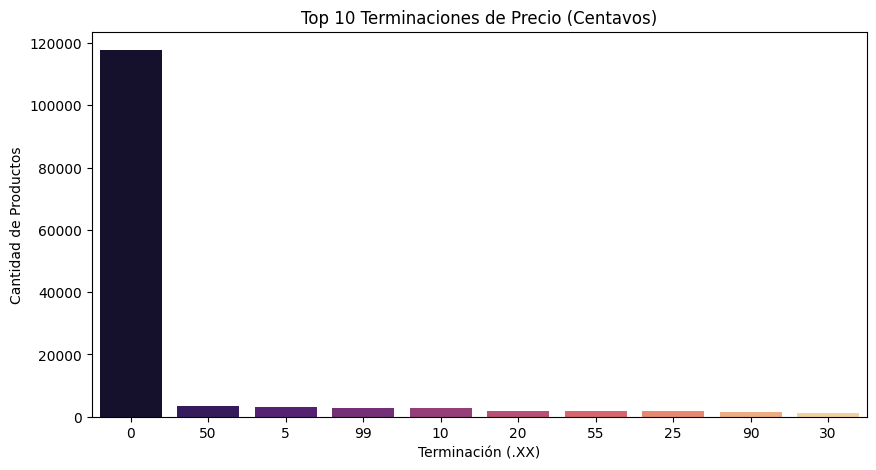

La terminación más común es: .00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_prices = df.dropna(subset=['price']).copy()
df_prices = df_prices[np.isfinite(df_prices['price'])]

df_prices['price_ending'] = (df_prices['price'] * 100).astype(int) % 100

plt.figure(figsize=(10, 5))
sns.countplot(
    x='price_ending',
    data=df_prices,
    order=df_prices['price_ending'].value_counts().iloc[:10].index,
    palette='magma'
)
plt.title('Top 10 Terminaciones de Precio (Centavos)')
plt.xlabel("Terminación (.XX)")
plt.ylabel("Cantidad de Productos")
plt.show()

top_ending = df_prices['price_ending'].mode()[0]
print(f"La terminación más común es: .{top_ending:02d}")

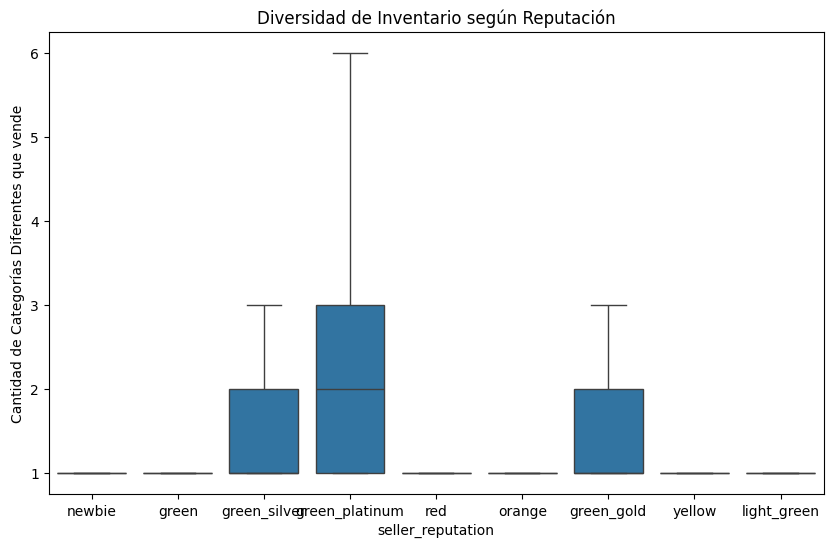

Promedio de categorías de un vendedor Green Gold: 2.26


In [ ]:
seller_diversity = df.groupby(['seller_nickname', 'seller_reputation'])['category_name'].nunique().reset_index()
seller_diversity.rename(columns={'category_name': 'unique_categories'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='seller_reputation', y='unique_categories', data=seller_diversity, showfliers=False)
plt.title('Diversidad de Inventario según Reputación')
plt.ylabel("Cantidad de Categorías Diferentes que vende")
plt.show()

avg_cats_gold = seller_diversity[seller_diversity['seller_reputation'] == 'green_gold']['unique_categories'].mean()
print(f"Promedio de categorías de un vendedor Green Gold: {avg_cats_gold:.2f}")

Los vendedores de élite no son tiendas departamentales que venden "de todo". Son especialistas de nicho. Con un promedio de apenas 2.26 categorías, el dato confirma que para llegar a ser Green Gold no necesitas ampliar tu oferta horizontalmente, sino profundizar en una vertical específica.

Top 10 Categorías con mayores descuentos (Mediana)
category_name
COLCHONES Y SOMIERES           45.006429
ILUMINACIÓN                    25.000000
HERRAMIENTAS PARA VEHÍCULOS    23.989966
VIDEOJUEGOS                    23.000000
COMPUTADORAS Y PORTÁTILES      20.000005
OTROS                          20.000000
DISPOSITIVOS WEARABLE          20.000000
BEBÉS                          20.000000
MUEBLES                        20.000000
ACCESORIOS NÁUTICOS            18.426703
Name: discount_pct, dtype: float64

Top 10 Logistica con mayores descuentos (Mediana)
logistic_type
FBM     25.001103
Otro    19.062310
FLEX    15.181305
XD      10.000000
DS       7.018724
Name: discount_pct, dtype: float64


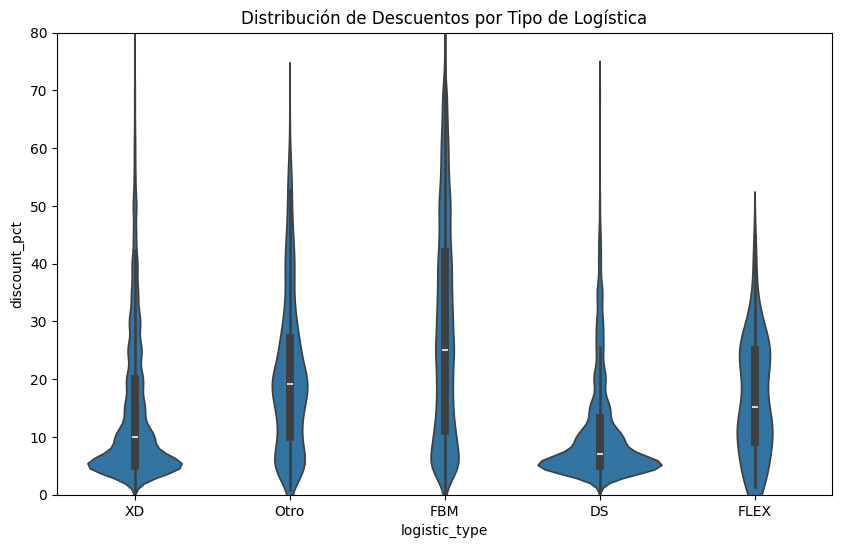

In [ ]:
df_discounts = df[df['discount_pct'] > 0]

cat_discount = df_discounts.groupby('category_name')['discount_pct'].median().sort_values(ascending=False).head(10)
log_discount = df_discounts.groupby('logistic_type')['discount_pct'].median().sort_values(ascending=False).head(10)

print("Top 10 Categorías con mayores descuentos (Mediana)")
print(cat_discount)

print()
print("Top 10 Logistica con mayores descuentos (Mediana)")
print(log_discount)

plt.figure(figsize=(10, 6))
sns.violinplot(x='logistic_type', y='discount_pct', data=df_discounts)
plt.title('Distribución de Descuentos por Tipo de Logística')
plt.ylim(0, 80)
plt.show()

* La categoría "Colchones y Somieres" rompe el mercado con una mediana de descuento del 45%, casi el doble que cualquier otra categoría.
* Los productos en FBM tienen los descuentos más agresivos (25%), mientras que Drop-Shipping (DS) tiene los más bajos (7%).

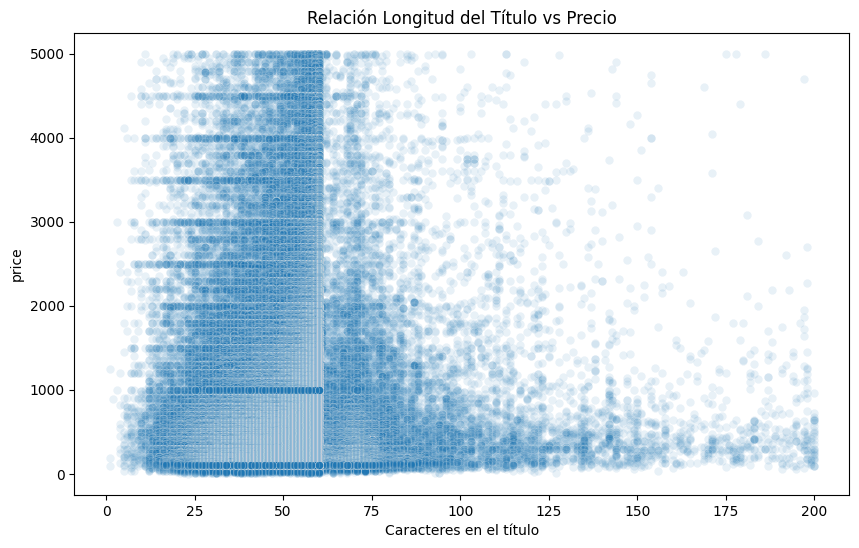

Porcentaje de títulos en MAYÚSCULAS por Reputación
is_all_caps             False     True 
seller_reputation                      
green              100.000000  0.000000
green_gold         100.000000  0.000000
green_platinum      99.998564  0.001436
green_silver       100.000000  0.000000
light_green        100.000000  0.000000
newbie              99.989155  0.010845
orange             100.000000  0.000000
red                100.000000  0.000000
yellow             100.000000  0.000000


In [ ]:
df['title_len'] = df['titulo'].astype(str).apply(len)
df['is_all_caps'] = df['titulo'].astype(str).apply(lambda x: x.isupper())

plt.figure(figsize=(10, 6))
sample_df = df[(df['price'] < 5000) & (df['price'] > 0)]
sns.scatterplot(x='title_len', y='price', data=sample_df, alpha=0.1)
plt.title('Relación Longitud del Título vs Precio')
plt.xlabel("Caracteres en el título")
plt.show()

caps_by_rep = pd.crosstab(df['seller_reputation'], df['is_all_caps'], normalize='index') * 100
print("Porcentaje de títulos en MAYÚSCULAS por Reputación")
print(caps_by_rep)

El 99.99% de los títulos estén en formato mixto

     Palabra  Frecuencia
0      color       11048
1      negro        6562
2        kit        5419
3     piezas        4143
4   original        4106
5        100        3203
6      sabor        3064
7      funda        2994
8     blanco        2946
9     hombre        2931
10     juego        2910
11     mujer        2860
12      tipo        2724
13       led        2645
14      caja        2641


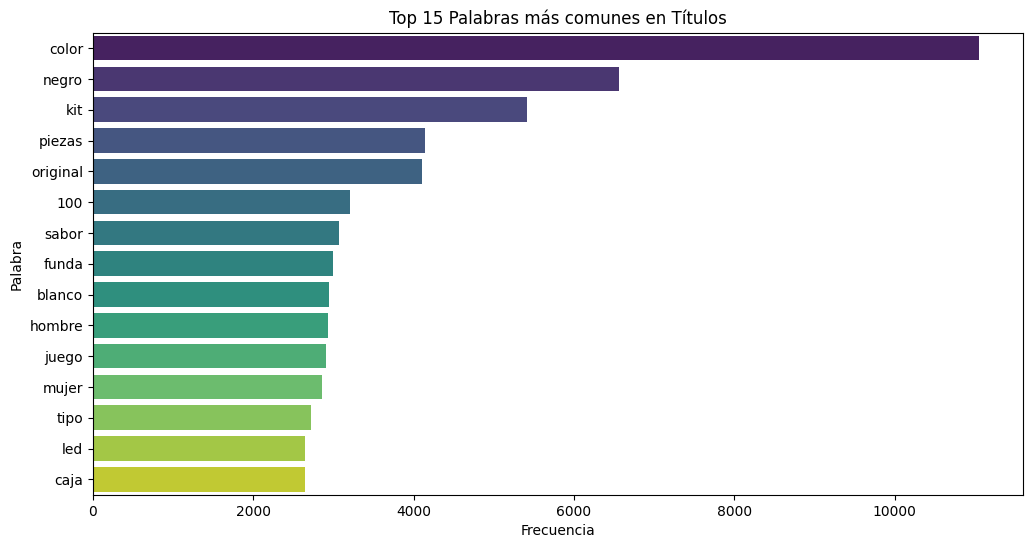

In [ ]:
from collections import Counter

all_titles = " ".join(df['titulo'].astype(str)).lower().split()

stop_words_simulated = ['de', 'con', 'y', 'para', 'en', 'el', 'la', 'un', 'una', 'a', 'del'] # Agregar más según necesidad
filtered_words = [word for word in all_titles if word not in stop_words_simulated and len(word) > 2]

word_counts = Counter(filtered_words).most_common(15)

words_df = pd.DataFrame(word_counts, columns=['Palabra', 'Frecuencia'])
print(words_df)
plt.figure(figsize=(12, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=words_df, palette='viridis')
plt.title('Top 15 Palabras más comunes en Títulos')
plt.show()

*   4 de las 15 palabras más usadas se refieren a conjuntos de productos. Los vendedores han descubierto que vender unidades sueltas no es rentable por los costos de envío. Para aumentar el Ticket Promedio y diluir el costo logístico, la estrategia ganadora es vender Packs o Kits. El usuario no busca una herramienta, busca un kit.
*   La palabra original aparece de quintas, superando a atributos físicos o descripciones de género. Esto revela una fricción de confianza en el ecosistema. Los compradores tienen miedo de recibir réplicas o falsificaciones.

In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Variables numéricas:", list(num_cols))
print("Variables categóricas:", list(cat_cols))


Variables numéricas: ['stock', 'price', 'regular_price', 'regular_price_clean', 'discount_pct', 'title_len']
Variables categóricas: ['seller_nickname', 'titulo', 'seller_reputation', 'logistic_type', 'condition', 'categoria', 'url', 'category_id', 'category_name', 'tld', 'seller_reputation_filled']


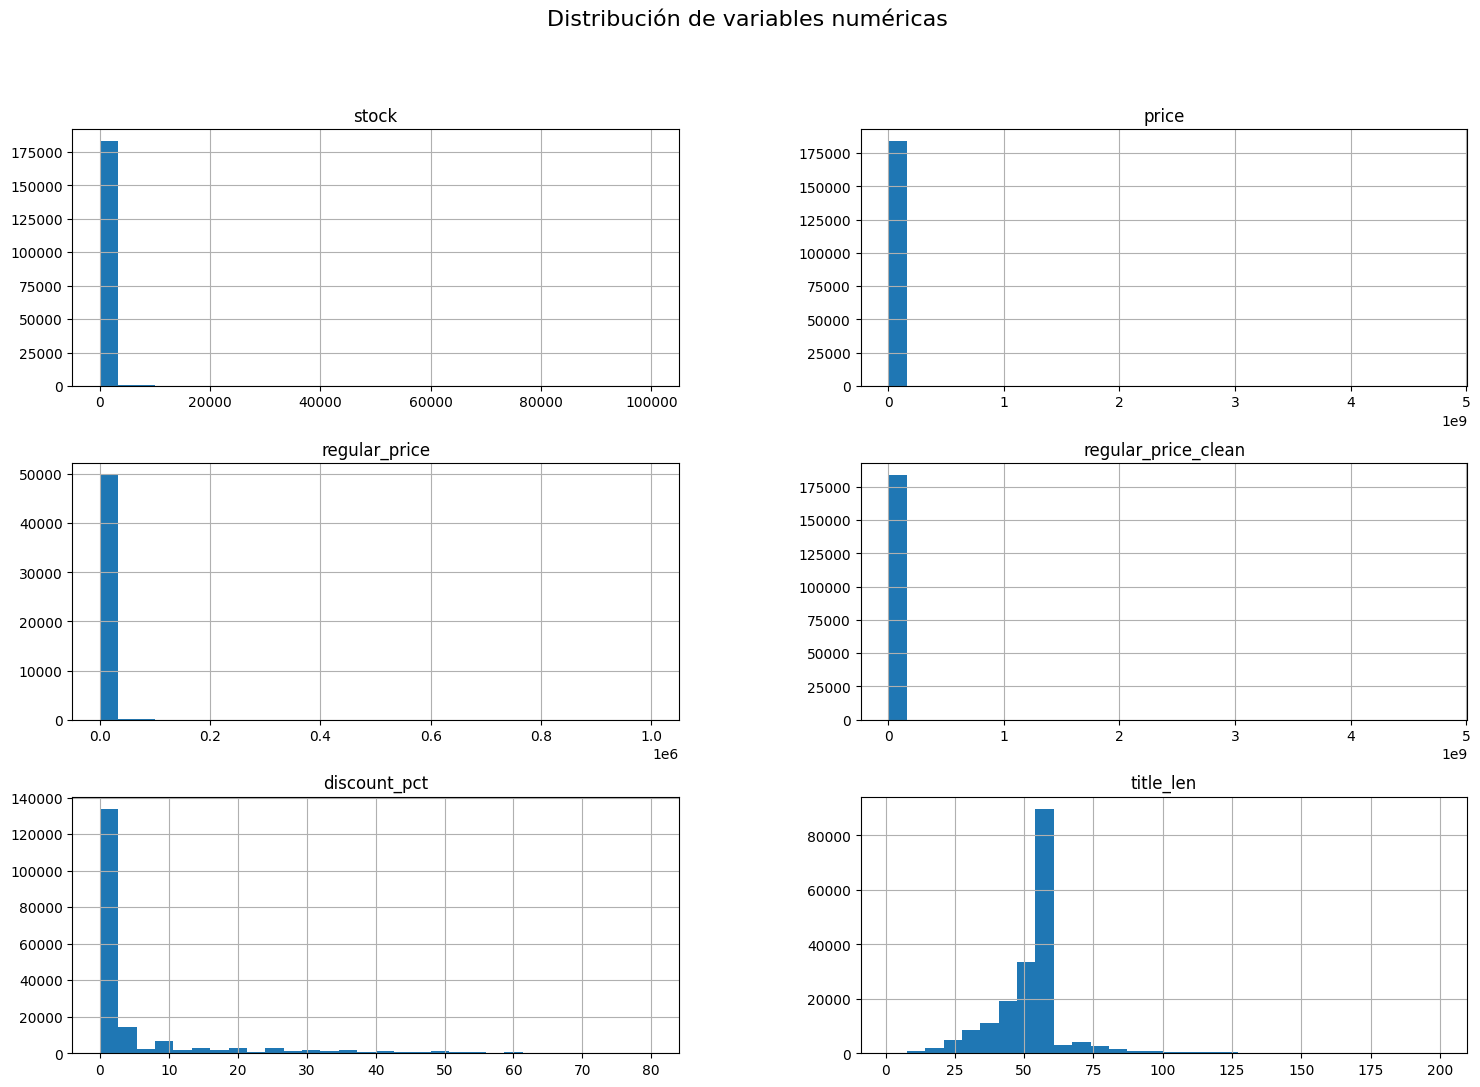

In [ ]:
df[num_cols].hist(bins=30, figsize=(18,12))
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

El 95% de los datos vive comprimido en valores bajos (precios $< 5,000$, stock $< 50$), mientras que unos pocos outliers de $4$ billones o stock de $99,999$ estiran la escala haciéndola ilegible.

                        stock     price  regular_price  regular_price_clean  \
stock                1.000000 -0.000188      -0.006386            -0.000187   
price               -0.000188  1.000000       0.991361             1.000000   
regular_price       -0.006386  0.991361       1.000000             1.000000   
regular_price_clean -0.000187  1.000000       1.000000             1.000000   
discount_pct         0.005757 -0.001387       0.008959            -0.001370   
title_len            0.002850 -0.001136       0.014276            -0.001134   

                     discount_pct  title_len  
stock                    0.005757   0.002850  
price                   -0.001387  -0.001136  
regular_price            0.008959   0.014276  
regular_price_clean     -0.001370  -0.001134  
discount_pct             1.000000   0.117624  
title_len                0.117624   1.000000  


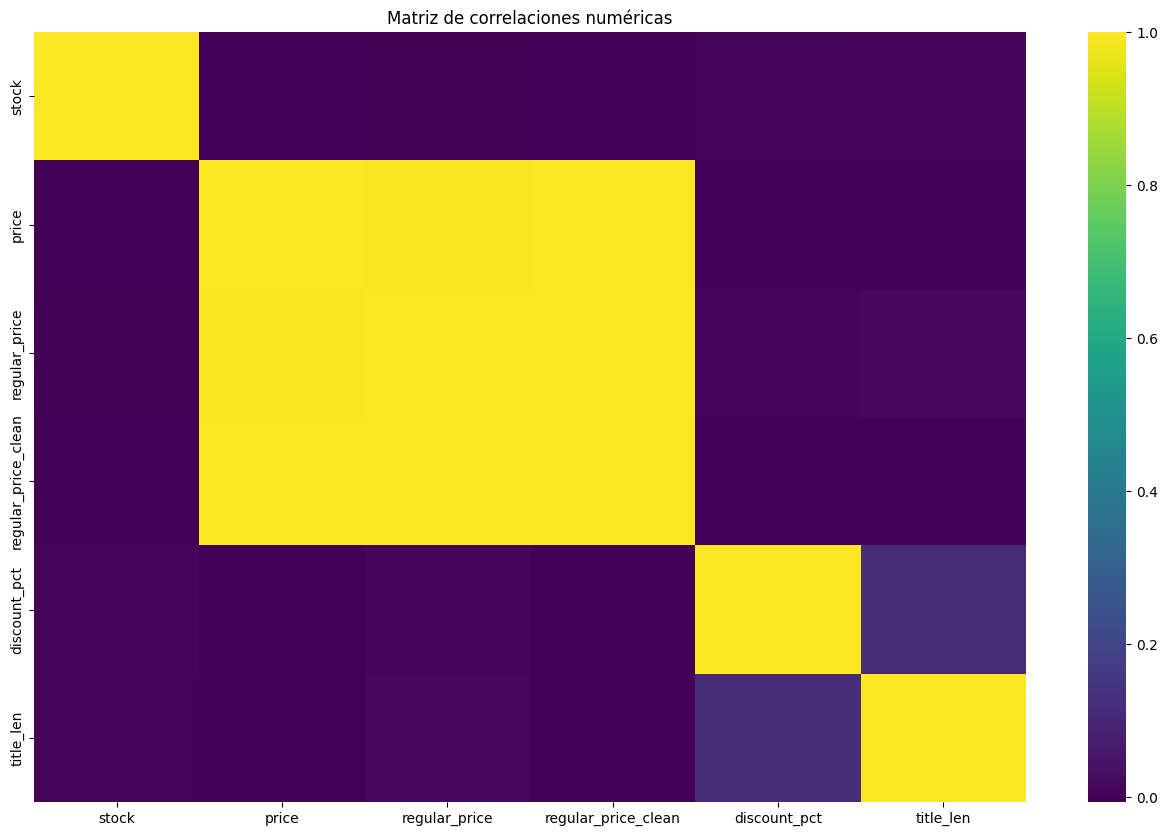

In [ ]:
corr= df[num_cols].corr()
print(corr)

plt.figure(figsize=(16,10))
sns.heatmap(corr, annot=False, cmap='viridis')
plt.title("Matriz de correlaciones numéricas")
plt.show()

Los productos con más texto tienen a ser los que tienen más Descuento

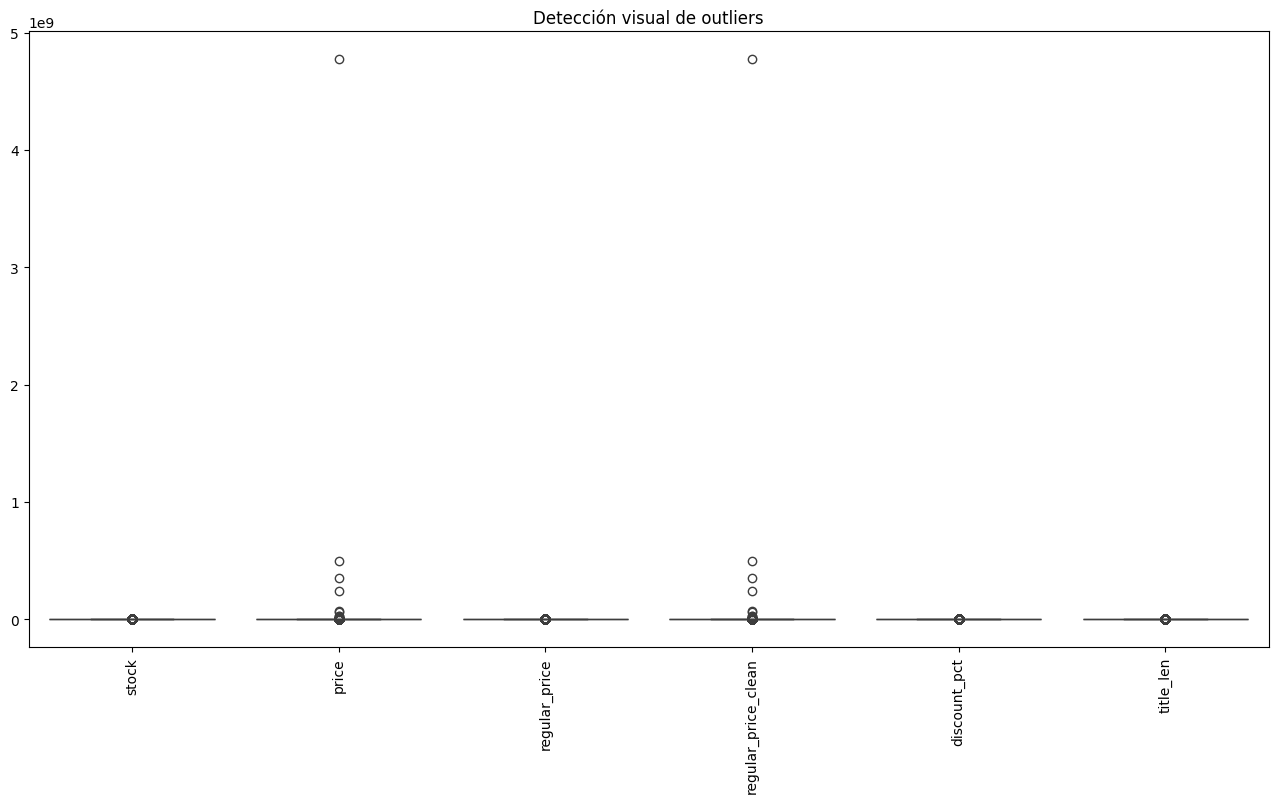

In [ ]:
plt.figure(figsize=(16,8))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=90)
plt.title("Detección visual de outliers")
plt.show()


## Analisis por seller

In [ ]:
seller_df = df.groupby("seller_nickname").agg({
    "price": ["mean", "median", "std", "min", "max"],
    "stock": ["sum", "mean", "median"],
    "condition": lambda x: (x == "new").mean(),
    "is_refurbished": "mean",
    "seller_reputation": lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan,
    "category_name": lambda x: x.mode()[0],
    "categoria": lambda x: x.mode()[0],
    "logistic_type": lambda x: x.mode()[0],
    "titulo": "count"
})

seller_df.columns = ['_'.join(col) for col in seller_df.columns]

seller_df = seller_df.reset_index()

seller_df.head()

,seller_nickname,price_mean,price_median,price_std,price_min,price_max,stock_sum,stock_mean,stock_median,condition_<lambda>,is_refurbished_mean,seller_reputation_<lambda>,category_name_<lambda>,categoria_<lambda>,logistic_type_<lambda>,titulo_count
0,000631669c,799.0,799.0,NaN,799.0,799.0,10,10.0,10.0,1.0,0.0,newbie,OTROS,OTHER,Otro,1
1,0007153bca,399.0,399.0,0.000000,399.0,399.0,55,27.5,27.5,1.0,0.0,green,OTROS,OTHER,XD,2
2,000bee3c3b,382.5,382.5,303.348809,168.0,597.0,0,0.0,0.0,1.0,0.0,newbie,"LIBROS, MULTIMEDIA Y OTROS","BOOKS, MULTIMEDIA & OTHER E!",XD,2
3,000df2bd02,1550.0,1550.0,NaN,1550.0,1550.0,5,5.0,5.0,0.0,0.0,green,ACCESORIOS PARA AUTOS Y CAMIONETAS,ACC CARS & VANS,XD,1
4,000e27cea2,457.5,457.5,229.809704,295.0,620.0,6,3.0,3.0,1.0,0.0,green_silver,ARTÍCULOS DEL HOGAR,HEALTH,FBM,2


La gran mayoría de los vendedores en Mercado Libre (especialmente los pequeños/newbies) son monoproducto o mono-temáticos. No son retailers complejos con estrategias de precios dinámicos; son personas vendiendo un stock específico y limitado. Esto facilita mucho la segmentación, ya que su comportamiento es predecible y estable: el que empieza vendiendo libros, se queda vendiendo libros.

Una vez perfilados los vendedores, debemos traducir sus características de negocio (categóricas y numéricas) para realizar el Clustering (K-Means)

In [ ]:
df_model = seller_df.copy()
df_model['price_std'] = df_model['price_std'].fillna(0)

reputation_map = {
    "newbie": 0,
    "yellow": 1,
    "green": 2,
    "green_silver": 3,
    "green_gold": 4,
    "platinum": 5,
    "green_platinum": 5
}

df_model['seller_reputation'] = df_model['seller_reputation_<lambda>'].map(reputation_map)

df_model = pd.get_dummies(df_model, columns=['logistic_type_<lambda>'], drop_first=True)

df_model = df_model.drop([
    "category_name_<lambda>",
    "categoria_<lambda>",
    "seller_reputation_<lambda>"
], axis=1)

df_model = df_model[df_model["price_mean"] > 0]

print("Shape final para clustering:", df_model.shape)
df_model.head()


Shape final para clustering: (46337, 17)


,seller_nickname,price_mean,price_median,price_std,price_min,price_max,stock_sum,stock_mean,stock_median,condition_<lambda>,is_refurbished_mean,titulo_count,seller_reputation,logistic_type_<lambda>_FBM,logistic_type_<lambda>_FLEX,logistic_type_<lambda>_Otro,logistic_type_<lambda>_XD
0,000631669c,799.0,799.0,0.000000,799.0,799.0,10,10.0,10.0,1.0,0.0,1,0.0,False,False,True,False
1,0007153bca,399.0,399.0,0.000000,399.0,399.0,55,27.5,27.5,1.0,0.0,2,2.0,False,False,False,True
2,000bee3c3b,382.5,382.5,303.348809,168.0,597.0,0,0.0,0.0,1.0,0.0,2,0.0,False,False,False,True
3,000df2bd02,1550.0,1550.0,0.000000,1550.0,1550.0,5,5.0,5.0,0.0,0.0,1,2.0,False,False,False,True
4,000e27cea2,457.5,457.5,229.809704,295.0,620.0,6,3.0,3.0,1.0,0.0,2,3.0,True,False,False,False


El modelo no agrupará solo por reputación, sino por intención operativa. Estamos permitiendo que el algoritmo descubra vendedores Newbies con mentalidad Platinum (que usan Cross-Docking y tienen buen stock, pero les falta antigüedad), diferenciándolos de los newbies pasivos (que usan logística propia y tienen stock 1). Esta distinción es crítica para detectar Rising Stars (futuras estrellas).

In [ ]:
df_cluster = df_model.copy()

num_cols = df_cluster.select_dtypes(include=[np.number]).columns
num_cols = [c for c in num_cols if c not in ['seller_reputation']]
# Winsorizar 1%-99%
for col in num_cols:
    lower = df_cluster[col].quantile(0.01)
    upper = df_cluster[col].quantile(0.99)
    df_cluster[col] = df_cluster[col].clip(lower, upper)

df_cluster.head()


,seller_nickname,price_mean,price_median,price_std,price_min,price_max,stock_sum,stock_mean,stock_median,condition_<lambda>,is_refurbished_mean,titulo_count,seller_reputation,logistic_type_<lambda>_FBM,logistic_type_<lambda>_FLEX,logistic_type_<lambda>_Otro,logistic_type_<lambda>_XD
0,000631669c,799.0,799.0,0.000000,799.0,799.0,10,10.0,10.0,1.0,0.0,1.0,0.0,False,False,True,False
1,0007153bca,399.0,399.0,0.000000,399.0,399.0,55,27.5,27.5,1.0,0.0,2.0,2.0,False,False,False,True
2,000bee3c3b,382.5,382.5,303.348809,168.0,597.0,0,0.0,0.0,1.0,0.0,2.0,0.0,False,False,False,True
3,000df2bd02,1550.0,1550.0,0.000000,1550.0,1550.0,5,5.0,5.0,0.0,0.0,1.0,2.0,False,False,False,True
4,000e27cea2,457.5,457.5,229.809704,295.0,620.0,6,3.0,3.0,1.0,0.0,2.0,3.0,True,False,False,False


Aplicamos winsorización en los datos para eliminar los extremos (top 1%), evitando que distorsionen la escala, permitiendo que el modelo finalmente distinga los matices entre vendedores pequeños y medianos, en lugar de agruparlos a todos como micro por comparación.

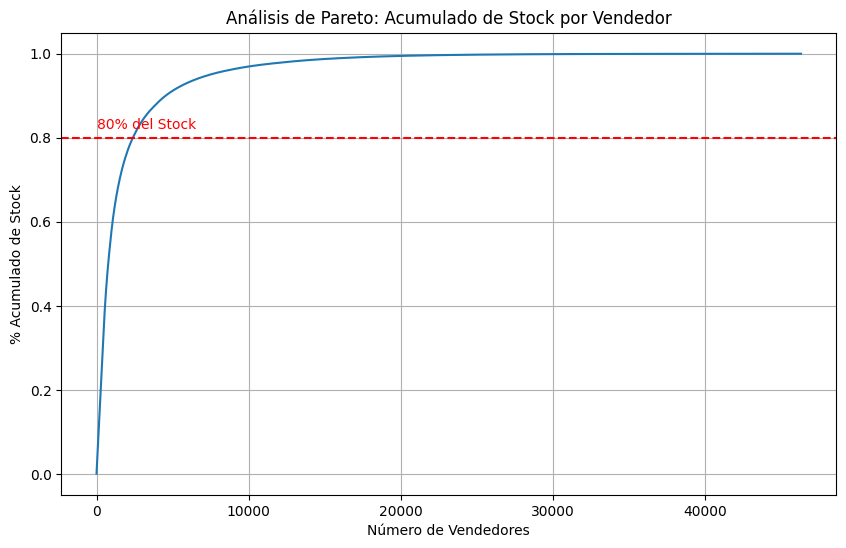

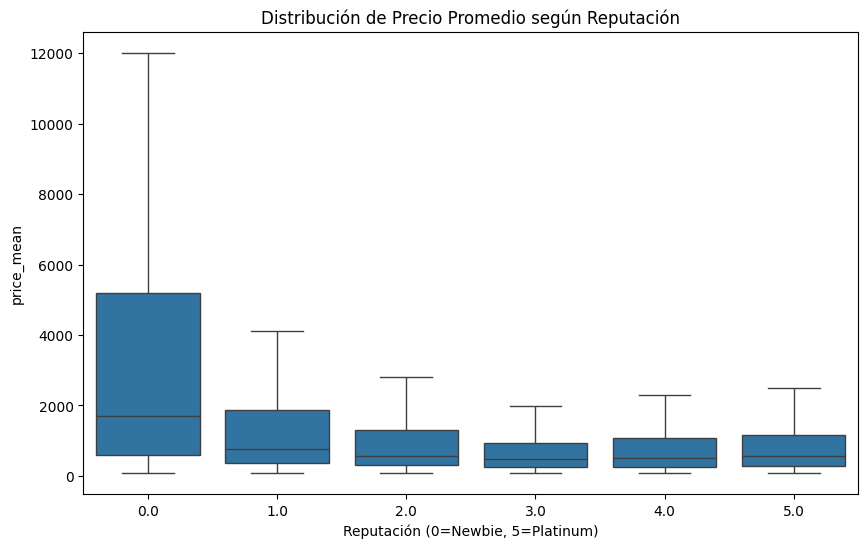

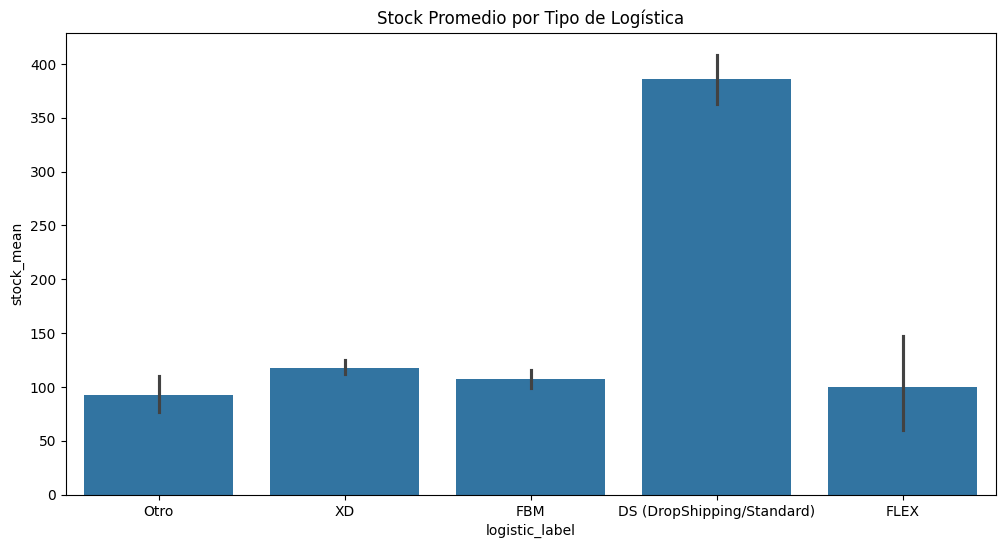

In [ ]:
# Pareto: ¿Pocos vendedores hacen la mayoría del stock/ventas?
plt.figure(figsize=(10, 6))
seller_volume = df_cluster.sort_values('stock_sum', ascending=False).reset_index()
seller_volume['cumulative_stock'] = seller_volume['stock_sum'].cumsum()
seller_volume['cumulative_perc'] = seller_volume['cumulative_stock'] / seller_volume['stock_sum'].sum()

plt.plot(seller_volume.index, seller_volume['cumulative_perc'])
plt.axhline(y=0.8, color='r', linestyle='--')
plt.title('Análisis de Pareto: Acumulado de Stock por Vendedor')
plt.xlabel('Número de Vendedores')
plt.ylabel('% Acumulado de Stock')
plt.text(0, 0.82, '80% del Stock', color='red')
plt.grid(True)
plt.show()

# Relación Precio vs Reputación
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cluster, x='seller_reputation', y='price_mean', showfliers=False)
plt.title('Distribución de Precio Promedio según Reputación')
plt.xlabel('Reputación (0=Newbie, 5=Platinum)')
plt.show()

# 3. Logística vs Stock (¿Quiénes usan Full/FBM?)
def get_logistic_label(row):
    if row['logistic_type_<lambda>_FBM']: return 'FBM'
    if row['logistic_type_<lambda>_FLEX']: return 'FLEX'
    if row['logistic_type_<lambda>_XD']: return 'XD'
    if row['logistic_type_<lambda>_Otro']: return 'Otro'
    return 'DS (DropShipping/Standard)'

df_cluster['logistic_label'] = df_cluster.apply(get_logistic_label, axis=1)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_cluster, x='logistic_label', y='stock_mean', estimator=np.mean)
plt.title('Stock Promedio por Tipo de Logística')
plt.show()

Aunque aplicamos Winsorización para recortar los extremos, los datos siguen sin ser normales. Por eso usamos RobustScaler.

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scale_cols = ['price_mean','price_median','price_std','price_min','price_max',
              'stock_sum','stock_mean','stock_median','condition_<lambda>',
              'is_refurbished_mean','titulo_count']

df_cluster_scaled = df_cluster.copy()
df_cluster_scaled[scale_cols] = scaler.fit_transform(df_cluster_scaled[scale_cols])

df_cluster_scaled.head()

,seller_nickname,price_mean,price_median,price_std,price_min,price_max,stock_sum,stock_mean,stock_median,condition_<lambda>,is_refurbished_mean,titulo_count,seller_reputation,logistic_type_<lambda>_FBM,logistic_type_<lambda>_FLEX,logistic_type_<lambda>_Otro,logistic_type_<lambda>_XD,logistic_label
0,000631669c,0.092483,0.154919,0.000000,0.378204,-0.041220,-0.039216,0.075000,0.151515,0.0,0.0,0.0,0.0,False,False,True,False,Otro
1,0007153bca,-0.180027,-0.154919,0.000000,-0.019905,-0.226476,0.401961,0.485156,0.681818,0.0,0.0,0.5,2.0,False,False,False,True,XD
2,000bee3c3b,-0.191268,-0.167699,1.183433,-0.249813,-0.134774,-0.137255,-0.159375,-0.151515,0.0,0.0,0.5,0.0,False,False,False,True,XD
3,000df2bd02,0.604122,0.736638,0.000000,1.125653,0.306599,-0.088235,-0.042187,0.000000,-1.0,0.0,0.0,2.0,False,False,False,True,XD
4,000e27cea2,-0.140173,-0.109605,0.896540,-0.123414,-0.124122,-0.078431,-0.089063,-0.060606,0.0,0.0,0.5,3.0,True,False,False,False,FBM


Antes de ejecutar el Clustering, aplicamos PCA. El PCA comprime esas 17 variables en 2 (PC1 y PC2) que capturan la mayor cantidad de información (varianza) posible.

* PC1: Capturar la magnitud del vendedor (¿Qué tan grande es?).
* PC2: Capturar la estrategia (¿Vende caro y poco, o barato y mucho?).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_coords = pca.fit_transform(df_cluster_scaled[scale_cols])

df_pca = pd.DataFrame(pca_coords, columns=['PC1','PC2'])
df_pca['seller_nickname'] = df_cluster_scaled['seller_nickname']
print(df_pca.head())
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

        PC1       PC2 seller_nickname
0 -7.275527 -2.834533      000631669c
1 -6.493738 -3.425719      0007153bca
2 -7.558611 -3.073490      000bee3c3b
3 -7.463589 -1.837016      000df2bd02
4 -7.445899 -3.039057      000e27cea2
Varianza explicada: 84.57%


La varianza del 84.57% confirma que las 17 variables originales estaban altamente correlacionadas

## Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df_cluster_scaled[scale_cols]

sil_scores = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores[k] = sil
    print(f"k={k} → silhouette={sil:.4f}")


k=2 → silhouette=0.9040
k=3 → silhouette=0.8870
k=4 → silhouette=0.8126
k=5 → silhouette=0.7943
k=6 → silhouette=0.7805
k=7 → silhouette=0.7567
k=8 → silhouette=0.7565
k=9 → silhouette=0.7641


Aunque k=2 es matemáticamente perfecto (0.90, "Vendedores vs No Vendedores"), elegimos k=4 (0.81) por utilidad de negocio. Un modelo de 2 grupos es inútil para operar. Con 4 grupos podemos segmentar: Top, Medios, Pequeños y Ocasionales.

In [ ]:
k_final = 4
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init='auto')

df_cluster_scaled['cluster'] = kmeans_final.fit_predict(X)

df_cluster_scaled['cluster'].value_counts()


,count
cluster,
0,43937
3,1106
2,658
1,636


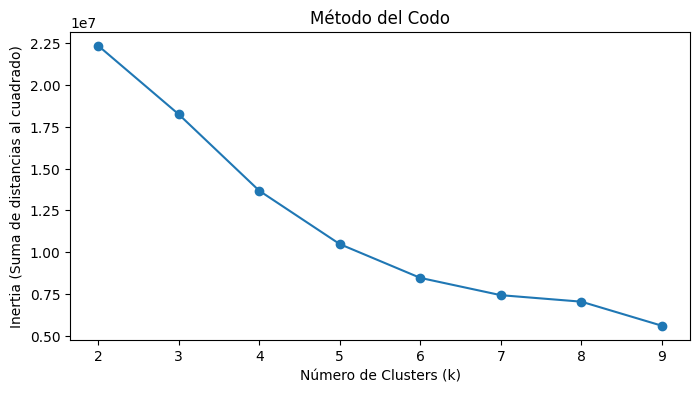

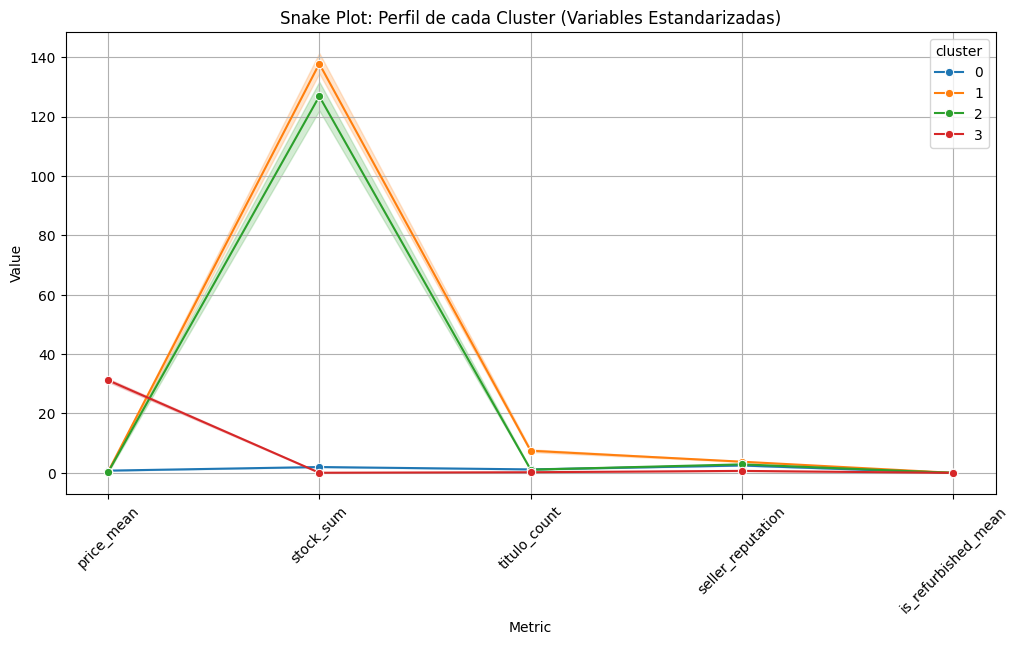

In [ ]:
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_cluster_scaled[scale_cols])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia (Suma de distancias al cuadrado)')
plt.show()

# Snake Plot
df_melt = pd.melt(df_cluster_scaled.reset_index(),
                  id_vars=['cluster'],
                  value_vars=['price_mean', 'stock_sum', 'titulo_count',
                              'seller_reputation', 'is_refurbished_mean'],
                  var_name='Metric',
                  value_name='Value')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melt, x='Metric', y='Value', hue='cluster', palette='tab10', marker="o")
plt.title('Snake Plot: Perfil de cada Cluster (Variables Estandarizadas)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
cluster_profile = df_cluster_scaled.groupby("cluster")[[
    "price_mean", "price_median", "price_std", "price_min", "price_max",
    "stock_sum", "stock_mean", "stock_median",
    "condition_<lambda>", "is_refurbished_mean", "titulo_count",
    "seller_reputation",
    "logistic_type_<lambda>_FBM",
    "logistic_type_<lambda>_FLEX",
    "logistic_type_<lambda>_Otro",
    "logistic_type_<lambda>_XD"
]].mean().round(3)

cluster_profile


,price_mean,price_median,price_std,price_min,price_max,stock_sum,stock_mean,stock_median,condition_<lambda>,is_refurbished_mean,titulo_count,seller_reputation,logistic_type_<lambda>_FBM,logistic_type_<lambda>_FLEX,logistic_type_<lambda>_Otro,logistic_type_<lambda>_XD
cluster,,,,,,,,,,,,,,,,
0,0.757,0.813,1.877,0.939,0.846,1.970,1.477,1.709,-0.187,0.0,1.173,2.480,0.166,0.000,0.063,0.628
1,0.272,0.053,3.687,-0.130,1.808,137.778,40.997,16.674,-0.002,0.0,7.458,3.764,0.108,0.014,0.020,0.429
2,0.146,0.114,1.102,0.151,0.202,126.813,105.993,112.795,-0.007,0.0,1.082,2.868,0.047,0.000,0.050,0.489
3,31.213,34.840,6.019,38.875,26.979,0.047,0.066,0.131,-0.627,0.0,0.216,0.669,0.008,0.000,0.500,0.333


1. Clúster 1: Los retailers gigantes
    * stock_sum altísimo (137) + titulo_count alto (7.4).
    * Son vendedores masivos con catálogos extensos. No venden un solo producto, venden cientos de SKUs diferentes (electrónica, hogar, moda).
    * Su precio promedio es bajo (0.27), lo que indica que compiten por volumen y rotación, no por margen unitario.

2. Clúster 2: Los mayoristas monoproducto
    * stock_mean monstruoso (106) pero titulo_count bajo (1.0).
    * A diferencia del Clúster 1, estos vendedores no tienen variedad. Tienen 1 o 2 publicaciones, pero con miles de unidades disponibles en cada una.
    * Hipótesis: Son fabricantes directos o distribuidores oficiales que usan Mercado Libre para mover cajas de un producto estrella

3. Clúster 3: High-Ticket / Venta Única
    * price_mean astronómico (31.2).
    * Venden productos extremadamente caros (Autos, Inmuebles, Maquinaria pesada).
    * Tienen stock_sum casi nulo (0.04) y condition negativa (-0.6, es decir, venden Usado).
    * Usan logística propia. No usan Mercado Envíos. Son vendedores de "una sola vez".

4. Clúster 0: La clase media
    * Valores cercanos a 0 o 1 en casi todo.
    * Es el 95% de los usuarios. Vendedores con stock moderado, precios estándar y reputación variada. Mantienen el ecosistema vivo por pura cantidad, aunque individualmente no muevan la aguja.

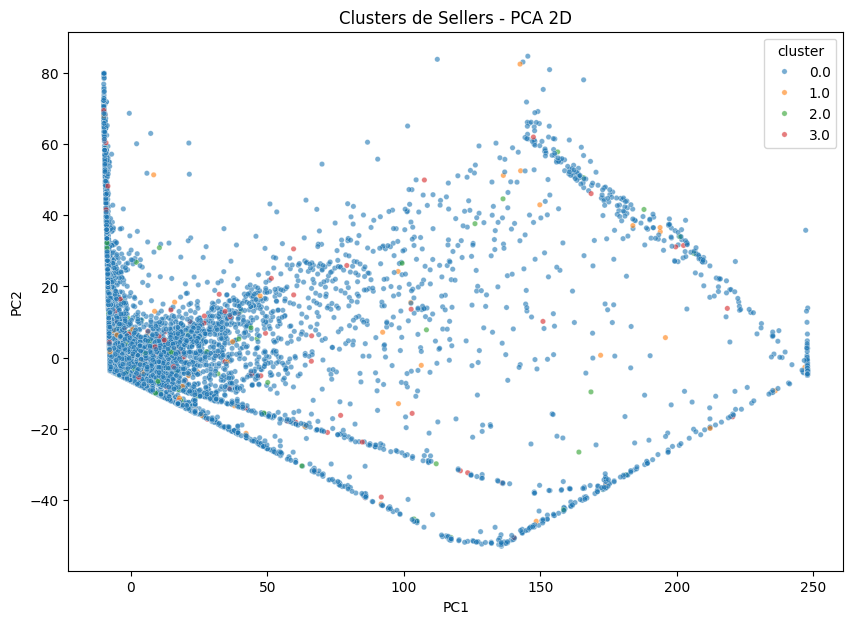

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=df_pca["PC1"],
    y=df_pca["PC2"],
    hue=df_cluster_scaled["cluster"],
    palette="tab10",
    alpha=0.6,
    s=15
)
plt.title("Clusters de Sellers - PCA 2D")
plt.show()


##Opción B – Recomendador Generativo de Estrategias Comerciales

In [100]:
import google.generativeai as genai
import json
from textwrap import dedent
import time
import os
import getpass

API_KEY = os.getenv("GEMINI_API_KEY")

if not API_KEY:
    print("No se detectó variable de entorno GEMINI_API_KEY.")
    API_KEY = getpass.getpass("🔑 Por favor, introduce tu API Key de Gemini: ")

if not API_KEY:
    print("Error: Se requiere una API Key para continuar.")
    exit()

genai.configure(api_key=API_KEY)

generation_config = {
  "temperature": 0.7,
  "top_p": 0.95,
  "top_k": 40,
  "max_output_tokens": 2048,
}

model = genai.GenerativeModel(
    model_name="models/gemini-2.5-flash",
    generation_config=generation_config
)

#  ARQUETIPOS
CLUSTER_PERSONAS = {
    0: {"nombre": "Clase Media", "descripcion": "Vendedor promedio.", "foco": "Mejorar calidad."},
    1: {"nombre": "Retailer Gigante", "descripcion": "Volumen alto, margen bajo.", "foco": "Logística Full y Cross-selling."},
    2: {"nombre": "Mayorista", "descripcion": "Pocos items, mucho stock.", "foco": "Venta B2B."},
    3: {"nombre": "High-Ticket", "descripcion": "Nicho caro, stock bajo.", "foco": "Confianza y Garantía."}
}

#  AGENTE
class SellerStrategyAgent:
    def __init__(self, model, cluster_personas):
        self.model = model
        self.personas = cluster_personas

    def _build_prompt(self, seller_data):
        cluster_id = seller_data.get('cluster', 0)
        persona = self.personas.get(cluster_id, self.personas[0])

        stats_text = (
            f"Cluster: {persona['nombre']}\n"
            f"Reputación: {seller_data.get('reputation_level')}\n"
            f"Precio Promedio: ${seller_data.get('avg_price')}\n"
            f"Items: {seller_data.get('total_items')}\n"
            f"Stock: {seller_data.get('total_stock')}"
        )

        prompt = dedent(f"""
        ACTÚA COMO: Consultor Senior de Mercado Libre.
        OBJETIVO: Crear un plan de acción para el siguiente vendedor.

        DATOS DEL VENDEDOR:
        {stats_text}

        INSTRUCCIONES IMPORTANTES:
        1. NO repitas los datos de entrada en tu respuesta. Ve directo al grano.
        2. Genera la respuesta en este formato estricto:
           - DIAGNÓSTICO: (1 frase resumen).
           - ESTRATEGIA 1: (Título y explicación).
           - ESTRATEGIA 2: (Título y explicación).
           - ESTRATEGIA 3: (Título y explicación).
           - KPI CLAVE: (Nombre de la métrica).

        FOCO SUGERIDO: {persona['foco']}
        """)
        return prompt

    def generate_strategy(self, seller_row):
        try:
            prompt = self._build_prompt(seller_row)
            response = self.model.generate_content(prompt)

            if response.candidates[0].finish_reason != 1:
                print(f"   ⚠️ Aviso: La generación se detuvo por razón: {response.candidates[0].finish_reason}")

            return response.text
        except Exception as e:
            return f"Error: {e}"


if __name__ == "__main__":
    if API_KEY and API_KEY != "TU_API_KEY_AQUI":
        agent = SellerStrategyAgent(model, CLUSTER_PERSONAS)

        lista_vendedores = [
            {'seller_id': 12345, 'cluster': 1, 'reputation_level': '5_green', 'avg_price': 450.5, 'total_items': 1500, 'total_stock': 5000},
            {'seller_id': 99887, 'cluster': 3, 'reputation_level': '3_yellow', 'avg_price': 150000.0, 'total_items': 5, 'total_stock': 5}
        ]

        resultados = []
        print("🤖 Procesando...")

        for seller in lista_vendedores:
            print(f"   -> Seller {seller['seller_id']}...")
            estrategia = agent.generate_strategy(seller)
            resultados.append({
                "seller_id": seller['seller_id'],
                "estrategia": estrategia
            })
            time.sleep(1.5)

        with open('estrategias_finales.json', 'w', encoding='utf-8') as f:
            json.dump(resultados, f, ensure_ascii=False, indent=4)

        print(" RESULTADO DEL PRIMER VENDEDOR")
        print(resultados[0]['estrategia'])
    else:
        print("Pon tu API Key.")

No se detectó variable de entorno GEMINI_API_KEY.
🔑 Por favor, introduce tu API Key de Gemini: ··········
🤖 Procesando...
   -> Seller 12345...
   -> Seller 99887...
 RESULTADO DEL PRIMER VENDEDOR
- DIAGNÓSTICO: Un retailer gigante con excelente reputación y amplio catálogo está listo para escalar significativamente su operación y rentabilidad mediante la optimización logística y la expansión estratégica del valor por cliente.

- ESTRATEGIA 1: Implementación Estratégica de Logística Full.
  Priorizar el envío de SKUs de alta rotación y margen al centro de Logística Full de Mercado Libre. Esto acelerará las entregas, mejorará la experiencia del comprador, reducirá la carga operativa del vendedor y aumentará la visibilidad de los productos en la plataforma.

- ESTRATEGIA 2: Maximización del Valor del Carrito con Cross-selling Inteligente.
  Analizar el comportamiento de compra para identificar productos complementarios y crear ofertas de packs, combos o sugerencias dinámicas ("otros comp

In [101]:
import json

# 1. Leer el archivo generado
with open('estrategias_finales.json', 'r', encoding='utf-8') as f:
    datos = json.load(f)

# 2. Imprimirlo con formato bonito (indentación)
print(json.dumps(datos, indent=4, ensure_ascii=False))

[
    {
        "seller_id": 12345,
        "estrategia": "- DIAGNÓSTICO: Un retailer gigante con excelente reputación y amplio catálogo está listo para escalar significativamente su operación y rentabilidad mediante la optimización logística y la expansión estratégica del valor por cliente.\n\n- ESTRATEGIA 1: Implementación Estratégica de Logística Full.\n  Priorizar el envío de SKUs de alta rotación y margen al centro de Logística Full de Mercado Libre. Esto acelerará las entregas, mejorará la experiencia del comprador, reducirá la carga operativa del vendedor y aumentará la visibilidad de los productos en la plataforma.\n\n- ESTRATEGIA 2: Maximización del Valor del Carrito con Cross-selling Inteligente.\n  Analizar el comportamiento de compra para identificar productos complementarios y crear ofertas de packs, combos o sugerencias dinámicas (\"otros compradores también vieron\") en las publicaciones. El objetivo es aumentar el ticket promedio por transacción y la exposición de todo 